### Init GD and Data


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from scipy.stats import boxcox, yeojohnson, shapiro, mannwhitneyu, chi2_contingency, probplot

In [38]:
bank_data = pd.read_csv('/content/drive/MyDrive/Data/bank_loan.csv')

### Functions

In [39]:
def show_and_imput_missing_values(df, columns):
    df = df.copy()  # avoid modifying original

    print("=== Missing Value Imputation Report ===")

    # Separate column types
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Handle numeric columns
    for col in numeric_cols:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            if columns and col in columns:
                df[col + '_missing'] = df[col].isna().astype(int)  # indicator column
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Numeric Column: '{col}' | Missing: {missing_count} | Filled with median ({median_val})")
            print("Unique values: " + str(df[col].unique()[0:10]) + "\n")
    # Handle categorical columns
    for col in categorical_cols:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            df[col] = df[col].fillna("Unknown")
            print(f"Categorical Column: '{col}' | Missing: {missing_count} | Filled with 'Unknown'")
            print("Unique values: " + str(df[col].unique()) + "\n")


    print("=== Imputation Complete ===\n")
    return df

In [78]:
from matplotlib.gridspec import GridSpec

def plot_categorical_vs_target(df, categorical_col, target_col):
    fig = plt.figure(figsize=(22, 14))
    fig.suptitle(f'Analysis of {target_col} by {categorical_col}', fontsize=16)

    # Use GridSpec: 2 rows, 3 cols
    gs = GridSpec(2, 3, figure=fig)

    # --- Big Pie Chart spanning first column ---
    freq_data = df[categorical_col].value_counts(sort=False)
    axbig = fig.add_subplot(gs[:, 0])  # span all rows in first column
    axbig.pie(
        freq_data,
        labels=freq_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("Pastel1", len(freq_data))
    )
    axbig.set_title('Frequency of Applicants')

    # --- Heatmap 1: Count of Approvals vs Denials ---
    ax1 = fig.add_subplot(gs[0, 1])
    count_table = pd.crosstab(df[categorical_col], df[target_col])
    sns.heatmap(data=count_table, annot=True, fmt='d', cmap=['white'],
                cbar=False, linecolor='lightgray', linewidths=0.5, ax=ax1)
    ax1.set_title('Approval Counts')
    ax1.set_xlabel('Loan Approved (0 = No, 1 = Yes)')
    ax1.set_ylabel('')

    # --- Heatmap 2: Approval Percentages ---
    ax2 = fig.add_subplot(gs[0, 2])
    percentage_table = pd.crosstab(df[categorical_col], df[target_col], normalize='index')
    sns.heatmap(data=percentage_table, annot=True, fmt='.2%', cmap=['white'],
                cbar=False, linecolor='lightgray', linewidths=0.5, ax=ax2)
    ax2.set_title('Approval Percentages')
    ax2.set_xlabel('Loan Approved (0 = No, 1 = Yes)')
    ax2.set_ylabel('')

    # --- Grouped Bar Chart: Target vs. Category ---
    ax3 = fig.add_subplot(gs[1, 1])
    count_table.plot(kind='bar', ax=ax3, colormap='RdYlGn', alpha=0.7)
    ax3.set_title('Approval Counts')
    ax3.set_xlabel(categorical_col)
    ax3.set_ylabel('Number of Applicants')
    ax3.legend(title='Loan Approved', labels=['Denied (0)', 'Approved (1)'])

        # --- Stacked Bar Chart: Percentage of target vs. category (100% Stacked Bar)  ---
    percentage_table = pd.crosstab(df[categorical_col], df[target_col], normalize='index')
    ax4 = fig.add_subplot(gs[1, 2])
    percentage_table.plot(kind='bar', stacked=True, ax=ax4, colormap='RdYlGn', alpha=0.7)
    ax4.set_title('Approval Percentages')
    ax4.set_xlabel(categorical_col)
    ax4.set_ylabel('Total Percentage')
    ax4.legend(title='Loan Approved', labels=['Denied (0)', 'Approved (1)'])

    plt.setp(ax4.get_xticklabels(), rotation=90, ha='right')

    plt.tight_layout()
    plt.show()

In [77]:
def describe_numeric_column(df, column):
    # histogram, KDE, boxplot for a numeric column.
    fig, axes = plt.subplots(2, 1, figsize=(10, 6),
                             gridspec_kw={'height_ratios': [3, 1]})

    # Histogram + KDE
    sns.histplot(df[column].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')

    # Boxplot
    sns.boxplot(x=df[column], ax=axes[1], color='lightgreen')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()
    univariate_analysis_godmode(df[column], plot=False)

def mann_whitney_u_test(df, target_col, col):

    approved = df[df[target_col] == 1][col]
    denied = df[df[target_col] == 0][col]
    print(f'Initiating Mann-Whitney U Test for {col} vs {target_col}, H0: No Effect, H1: Has Effect')
    ustat, p_value = stats.mannwhitneyu(approved, denied)
    print(f"U-Statistic: {ustat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print('Conclusion:', end=' ')
    if p_value > 0.05:
        print('Fail to reject H0.')
        print(f"There's no statistically significant evidence that {col} has an effect on {target_col}.")
    else:
        print('Reject H0.')
        print(f"There's statistically significant evidence that {col} has an effect on {target_col}.")


def univariate_analysis_godmode(series, plot=True):
    col_name = series.name

    if pd.api.types.is_numeric_dtype(series):
        median_val = series.median()
        mode_val = series.mode()[0] if not series.mode().empty else np.nan
        mean_val = series.mean()
        std_val = series.std()
        min_val = series.min()
        max_val = series.max()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        outliers = series[(series < q1 - 1.5 * iqr) | (series > q3 + 1.5 * iqr)]
        skew_val = skew(series)
        kurt_val = kurtosis(series)

        try:
            stat, p_value = shapiro(series)
            normality = "Normal" if p_value > 0.05 else "Not Normal"
        except:
            normality = "Test Failed"

        if normality == "Normal":
            distribution_type = "Normal"
        else:
            if skew_val > 0.5:
                distribution_type = "Right-skewed"
            elif skew_val < -0.5:
                distribution_type = "Left-skewed"
            else:
                distribution_type = "Approximately Symmetric"

        report = {
            "count": len(series),
            "mean": mean_val,
            "median": median_val,
            "mode": mode_val,
            "std": std_val,
            "min": min_val,
            "25%": q1,
            "75%": q3,
            "max": max_val,
            "skew": skew_val,
            "kurtosis": kurt_val,
            "outlier_count": len(outliers),
            "normality": normality,
            "distribution_type": distribution_type,
            "missing values": series.isna().sum()
        }

        print(f"\n=== {col_name} Analysis ===")
        df_report = pd.DataFrame(report, index=[0]).T.rename(columns={0: 'Value'})
        print(df_report)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.histplot(series, kde=True)
            plt.title(f"{col_name} - Histogram")
            plt.subplot(1, 2, 2)
            sns.boxplot(x=series)
            plt.title(f"{col_name} - Boxplot")
            plt.show()

    else:
        value_counts = series.value_counts()
        percentages = (value_counts / len(series) * 100).round(2)
        report = pd.DataFrame({
            "count": value_counts,
            "percentage": percentages
        })

        print(f"\n=== {col_name} Analysis ===")
        print(report)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.countplot(x=series, order=value_counts.index)
            plt.title(f"{col_name} - Countplot")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    return df_report

In [84]:
def plot_numerical_vs_target(data, feature_col, target_col):
    data = data.copy()
    groups = data[target_col].unique()

    fig, axes = plt.subplots(2, 3, figsize=(22, 14))
    fig.suptitle(f"Analysis of {feature_col} vs {target_col}", fontsize=16)

    # --- Histogram + KDE ---
    ax = axes[0,0]
    sns.histplot(data, x=feature_col, hue=target_col, kde=True,
                 element="step", stat="density", common_norm=False,
                 ax=ax, palette="Pastel1", alpha=0.6)
    for g in groups:
        vals = data.loc[data[target_col] == g, feature_col].dropna()
        ax.axvline(vals.mean(), linestyle="--", linewidth=1.2,
                   label=f"Mean (target={g}): {vals.mean():.2f}")
        ax.axvline(vals.median(), linestyle=":", linewidth=1.2,
                   label=f"Median (target={g}): {vals.median():.2f}")
    ax.set_title("Histogram + KDE with mean/median")
    ax.set_xlabel(feature_col)
    ax.set_ylabel("Density")
    ax.legend()

    # --- Boxplot ---
    sns.boxplot(data=data, x=target_col, y=feature_col,
                palette="Pastel1", showmeans=True, ax=axes[0,1])
    axes[0,1].set_title("Boxplot")
    axes[0,1].set_xlabel(target_col)
    axes[0,1].set_ylabel(feature_col)

    # --- Violin plot ---
    sns.violinplot(data=data, x=target_col, y=feature_col,
                   palette="Pastel1", inner="box", ax=axes[0,2])
    axes[0,2].set_title("Violin plot")
    axes[0,2].set_xlabel(target_col)
    axes[0,2].set_ylabel(feature_col)

    # --- Barplot (Mean ± SE) ---
    sns.barplot(data=data, x=target_col, y=feature_col,
                estimator="mean", errorbar="se", palette="RdYlGn", ax=axes[1,0])
    axes[1,0].set_title("Mean ± SE by target")
    axes[1,0].set_xlabel(target_col)
    axes[1,0].set_ylabel(f"Mean {feature_col}")

    # --- Q-Q Plot ---
    for g in groups:
        sample = data.loc[data[target_col]==g, feature_col].dropna()
        stats.probplot(sample, dist="norm", plot=axes[1,1])
    axes[1,1].set_title("Q-Q plot per group")
    axes[1,1].set_xlabel("Theoretical quantiles")
    axes[1,1].set_ylabel("Sample quantiles")

    # --- Strip plot ---
    sns.stripplot(data=data, x=target_col, y=feature_col,
                  palette="Pastel1", alpha=0.6, jitter=True, ax=axes[1,2])
    axes[1,2].set_title("Strip plot")
    axes[1,2].set_xlabel(target_col)
    axes[1,2].set_ylabel(feature_col)

    plt.tight_layout()
    plt.show()

from itertools import combinations
def compare_group_chi2(df, group_col, target_col, alpha=0.05):

    contingency_table = pd.crosstab(df[group_col], df[target_col])

    print("Initiating CHI-square test:")

    categories = df[group_col].unique()
    print("Categories to compare:", categories)

    category_pairs = list(combinations(categories, 2))

    results = []

    for group1, group2 in category_pairs:

        subset = df[df[group_col].isin([group1, group2])]

        contingency_table = pd.crosstab(subset[group_col], subset[target_col])

        # Perform chi-squared test
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        if p_value < alpha:
            print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        else:
            print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")



In [85]:
def correlation_with_target(data, target_col, alpha=0.05):
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_col]

    results = []

    for col in numeric_cols:
        group0 = data.loc[data[target_col] == 0, col].dropna()
        group1 = data.loc[data[target_col] == 1, col].dropna()

        if group0.nunique() < 2 or group1.nunique() < 2:
            results.append([col, "N/A", np.nan, np.nan, "Insufficient variance"])
            continue

        # --- Normality tests ---
        def normality_test(sample):
            if len(sample) < 50:
                stat, p = stats.shapiro(sample)
                return p > alpha, "Shapiro"
            else:
                # KS test against normal distribution
                stat, p = stats.kstest((sample - sample.mean())/sample.std(ddof=1), 'norm')
                return p > alpha, "KS"

        norm0, method0 = normality_test(group0)
        norm1, method1 = normality_test(group1)

        # --- Variance test (Levene) ---
        _, p_levene = stats.levene(group0, group1)
        equal_var = p_levene > alpha

        # --- Choose test ---
        if norm0 and norm1:
            if equal_var:
                test_name = "t-test (independent)"
                stat, p_val = stats.ttest_ind(group0, group1, equal_var=True)
            else:
                test_name = "Welch’s t-test"
                stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
        else:
            test_name = "Mann–Whitney U"
            stat, p_val = stats.mannwhitneyu(group0, group1, alternative='two-sided')

        results.append([
            col,
            test_name,
            stat,
            p_val,
            "Significant" if p_val < alpha else "Not significant",
            f"{method0}/{method1}",
            f"{'Equal var' if equal_var else 'Unequal var'}"
        ])

    results_df = pd.DataFrame(results, columns=[
        "Feature", "Test Used", "Statistic", "P-value", "Result", "Normality Tests", "Variance Assumption"
    ])
    return results_df

### Initial Data glimpse

In [44]:
bank_data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore,LoanApproved
0,2072-08-01,22,63052,631,Employed,Master,2,18271,12,Married,...,5254.333333,0.639338,3.0,1409,0.167771,0.156702,1654.893043,0.397366,51.0,0
1,2068-04-14,42,62117,522,Employed,Associate,20,29281,108,Divorced,...,5176.416667,0.835783,5.0,106328,0.313281,0.294022,774.117592,0.190888,50.0,0
2,2062-04-07,31,32448,544,Employed,Bachelor,5,33395,60,Divorced,...,2704.000000,0.879069,3.0,8626,0.266395,0.286945,1053.817922,0.531368,54.0,0
3,2031-05-29,19,32182,478,Unemployed,Master,0,49105,24,Single,...,2681.833333,0.868833,7.0,96744,0.285105,0.247245,2614.025710,1.125732,53.0,0
4,2024-04-04,45,77191,646,Employed,Master,21,99655,24,Married,...,6432.583333,0.982722,8.0,16312,0.251655,0.256010,5348.835792,0.924642,52.0,0


In [45]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             2050 non-null   object 
 1   Age                         2050 non-null   int64  
 2   AnnualIncome                2050 non-null   int64  
 3   CreditScore                 2050 non-null   int64  
 4   EmploymentStatus            1976 non-null   object 
 5   EducationLevel              2050 non-null   object 
 6   Experience                  2050 non-null   int64  
 7   LoanAmount                  2050 non-null   object 
 8   LoanDuration                2050 non-null   int64  
 9   MaritalStatus               2050 non-null   object 
 10  NumberOfDependents          1963 non-null   float64
 11  HomeOwnershipStatus         1951 non-null   object 
 12  MonthlyDebtPayments         2009 non-null   float64
 13  CreditCardUtilizationRate   2050 

In [46]:
bank_data.describe()

,Age,AnnualIncome,CreditScore,Experience,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore,LoanApproved
count,2050.000000,2.050000e+03,2050.000000,2050.000000,2050.000000,1963.000000,2009.000000,2050.000000,2050.000000,2050.000000,...,2050.000000,2050.000000,1936.000000,2.050000e+03,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000
mean,39.952195,1.558224e+05,572.662927,17.353659,54.058537,1.455425,457.295669,0.294761,2.848780,0.968780,...,4759.490569,0.791977,5.076963,7.737341e+04,0.240882,0.240792,931.094014,0.405455,50.774927,0.239024
std,11.702246,9.780950e+05,63.820500,11.614698,24.404283,1.367463,239.521001,0.162348,1.899773,0.969018,...,3156.760304,0.122874,2.229185,1.340863e+05,0.035993,0.042887,710.769016,0.334684,7.745501,0.426592
min,18.000000,1.500000e+04,384.000000,-4.000000,12.000000,0.000000,85.000000,0.004364,-4.000000,0.000000,...,625.000000,0.276100,0.000000,1.018000e+03,0.130338,0.113310,118.491581,0.034436,30.400000,0.000000
25%,32.000000,3.274900e+04,538.000000,9.000000,36.000000,0.000000,289.000000,0.169033,2.000000,0.000000,...,2586.062500,0.712901,3.000000,9.073750e+03,0.215449,0.210321,511.277136,0.180706,46.000000,0.000000
50%,40.000000,4.926900e+04,575.000000,17.000000,48.000000,1.000000,405.000000,0.278739,3.000000,1.000000,...,3869.750000,0.809762,5.000000,3.569450e+04,0.238110,0.237375,735.522113,0.305972,51.000000,0.000000
75%,48.000000,7.434200e+04,608.000000,25.000000,72.000000,2.000000,568.000000,0.401770,4.000000,2.000000,...,5931.875000,0.887293,6.000000,9.202675e+04,0.264231,0.268571,1118.015055,0.518579,56.000000,0.000000
max,80.000000,1.000000e+07,950.000000,60.000000,120.000000,5.000000,2375.000000,0.835776,10.000000,5.000000,...,21606.500000,0.996563,12.000000,1.645402e+06,0.384555,0.395984,7859.855080,4.143180,76.000000,1.000000


### NaN Values Handeling

In [47]:
bank_data = show_and_imput_missing_values(bank_data, bank_data.columns.tolist())

=== Missing Value Imputation Report ===
Numeric Column: 'NumberOfDependents' | Missing: 87 | Filled with median (1.0)
Unique values: [1. 0. 4. 3. 2. 5.]

Numeric Column: 'MonthlyDebtPayments' | Missing: 41 | Filled with median (405.0)
Unique values: [433. 214. 383. 405. 599. 248. 452. 518. 525. 392.]

Numeric Column: 'JobTenure' | Missing: 114 | Filled with median (5.0)
Unique values: [ 3.  5.  7.  8.  4.  2.  6. 10.  9. 11.]

Categorical Column: 'EmploymentStatus' | Missing: 74 | Filled with 'Unknown'
Unique values: ['Employed' 'Unemployed' 'Self-Employed' 'Unknown']

Categorical Column: 'HomeOwnershipStatus' | Missing: 99 | Filled with 'Unknown'
Unique values: ['Other' 'Rent' 'Mortgage' 'Own' 'Unknown']

=== Imputation Complete ===



### My Data I have to Analyse

## Applicant's Personal & Employment Details
- ApplicationDate: (Date Object) The date the loan application was submitted.
- Age: (Numeric) The applicant's age in years.
- MaritalStatus: (Category) The applicant's marital status.
- NumberOfDependents: (Numeric) How many people rely on the applicant financially.
- EducationLevel: (Categorical) The highest level of education the applicant has completed.
- EmploymentStatus: (Category) The applicant's current employment situation.
- Experience: (Numeric) The applicant's total years of professional experience.
- JobTenure: (Numeric) How long the applicant has been at their current job, usually in years.
- HomeOwnershipStatus: (Category) Whether the applicant rents, owns their home, or has a mortgage.

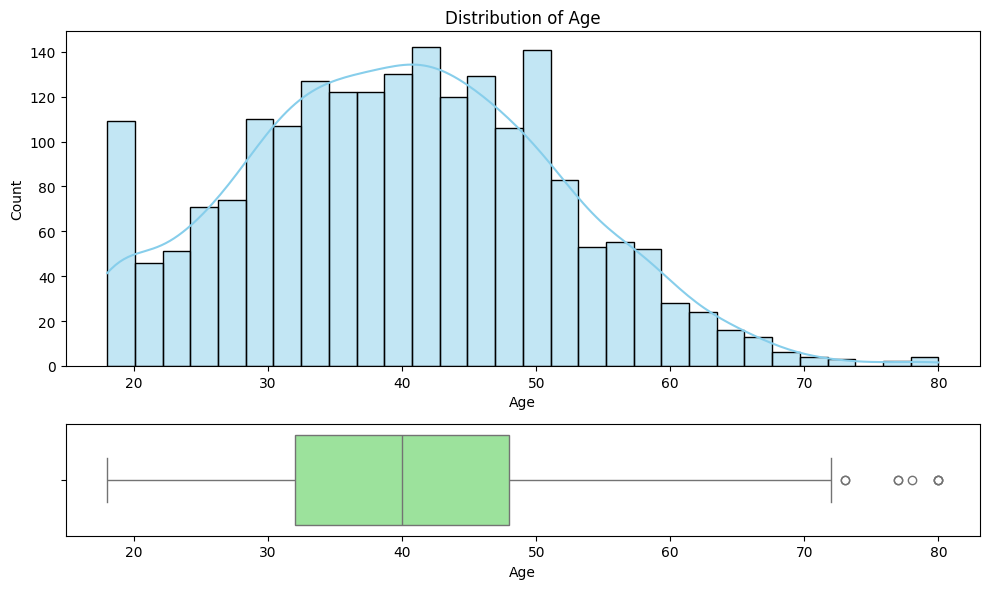


=== Age Analysis ===
                                     Value
count                                 2050
mean                             39.952195
median                                40.0
mode                                    18
std                              11.702246
min                                     18
25%                                   32.0
75%                                   48.0
max                                     80
skew                              0.188908
kurtosis                         -0.299357
outlier_count                            8
normality                       Not Normal
distribution_type  Approximately Symmetric
missing values                           0


In [90]:
describe_numeric_column(bank_data, 'Age')

Distriibution: Right skewed.

Has outliers past 80, however could be left alone

Most Values are between 30 and 50

/tmp/ipython-input-1758682694.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column], ax=axes[0], palette="Set2", order=df[column].value_counts().index)


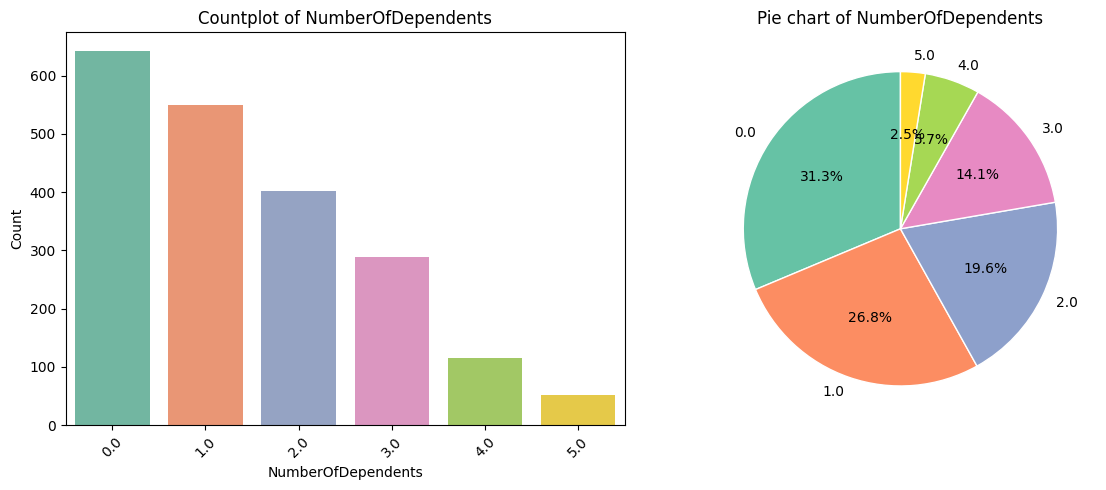

,NumberOfDependents
count,2050.000000
mean,1.436098
std,1.341264
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,5.000000


In [95]:
plot_categorical_distribution(bank_data, 'NumberOfDependents')
bank_data['NumberOfDependents'].describe()

Distribution: discrete

About 60% are with No or One Dependents


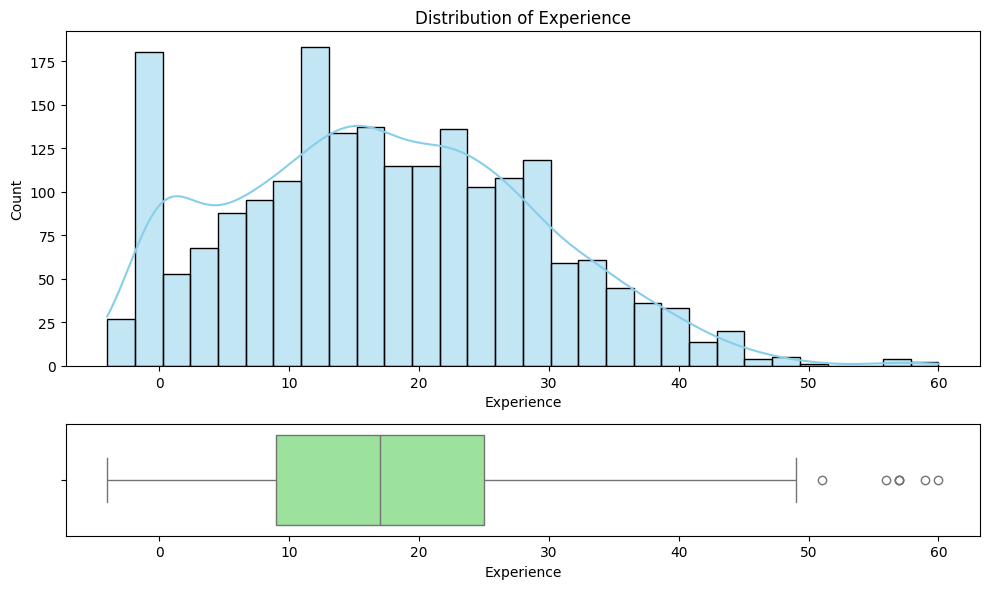


=== Experience Analysis ===
                                     Value
count                                 2050
mean                             17.353659
median                                17.0
mode                                     0
std                              11.614698
min                                     -4
25%                                    9.0
75%                                   25.0
max                                     60
skew                              0.312799
kurtosis                         -0.370848
outlier_count                            7
normality                       Not Normal
distribution_type  Approximately Symmetric
missing values                           0


In [92]:
describe_numeric_column(bank_data, 'Experience')

Distriibution: Right skewed.

Has outliers past 50 (Should check if they are logical)

There are nome data with lower than 0 values DEFINATLY not normal

Most Values are between 10 and 20 years

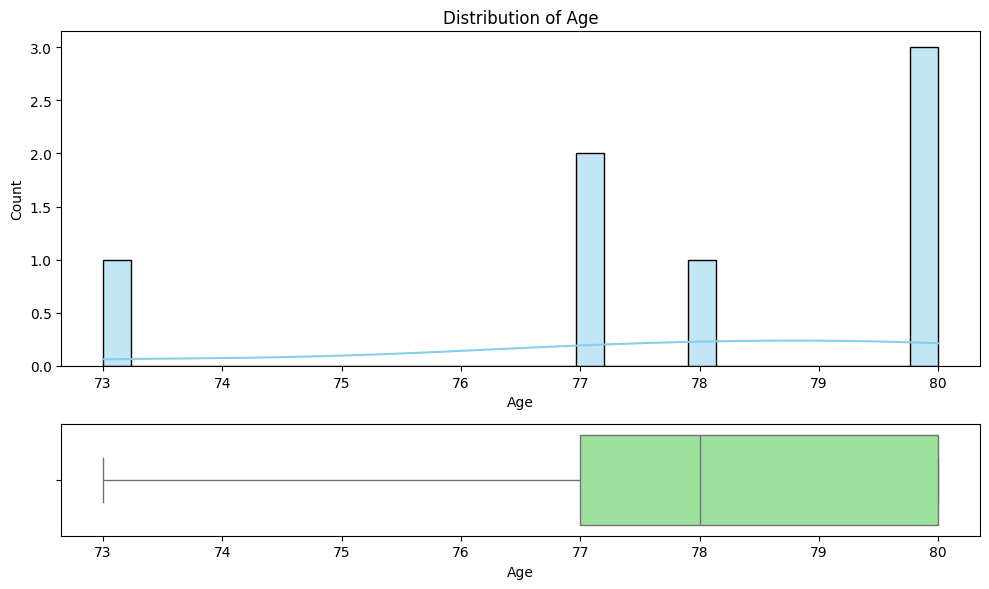


=== Age Analysis ===
                       Value
count                      7
mean               77.857143
median                  78.0
mode                      80
std                 2.544836
min                       73
25%                     77.0
75%                     80.0
max                       80
skew               -0.942946
kurtosis           -0.121378
outlier_count              0
normality             Normal
distribution_type     Normal
missing values             0


In [93]:
describe_numeric_column(bank_data[bank_data['Experience'] > 50], 'Age')

It actually is logical

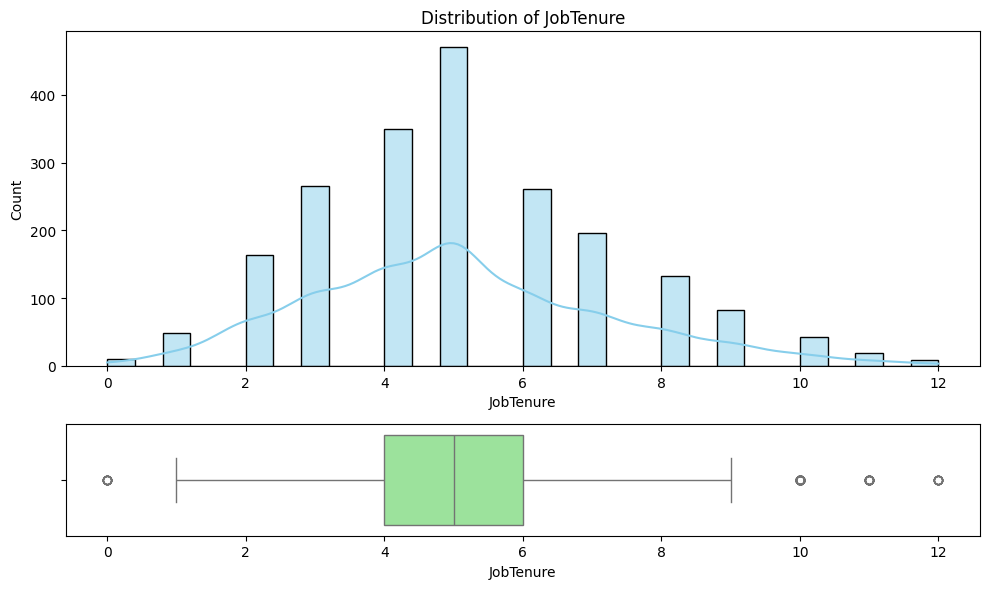


=== JobTenure Analysis ===
                                     Value
count                                 2050
mean                              5.072683
median                                 5.0
mode                                   5.0
std                               2.166357
min                                    0.0
25%                                    4.0
75%                                    6.0
max                                   12.0
skew                               0.45928
kurtosis                          0.093956
outlier_count                           80
normality                       Not Normal
distribution_type  Approximately Symmetric
missing values                           0


In [94]:
describe_numeric_column(bank_data, 'JobTenure')

Distribution: disctete

Most are between 4 and 7 years

There are no Logical Outlier

## Data Vs target

/tmp/ipython-input-3032345582.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

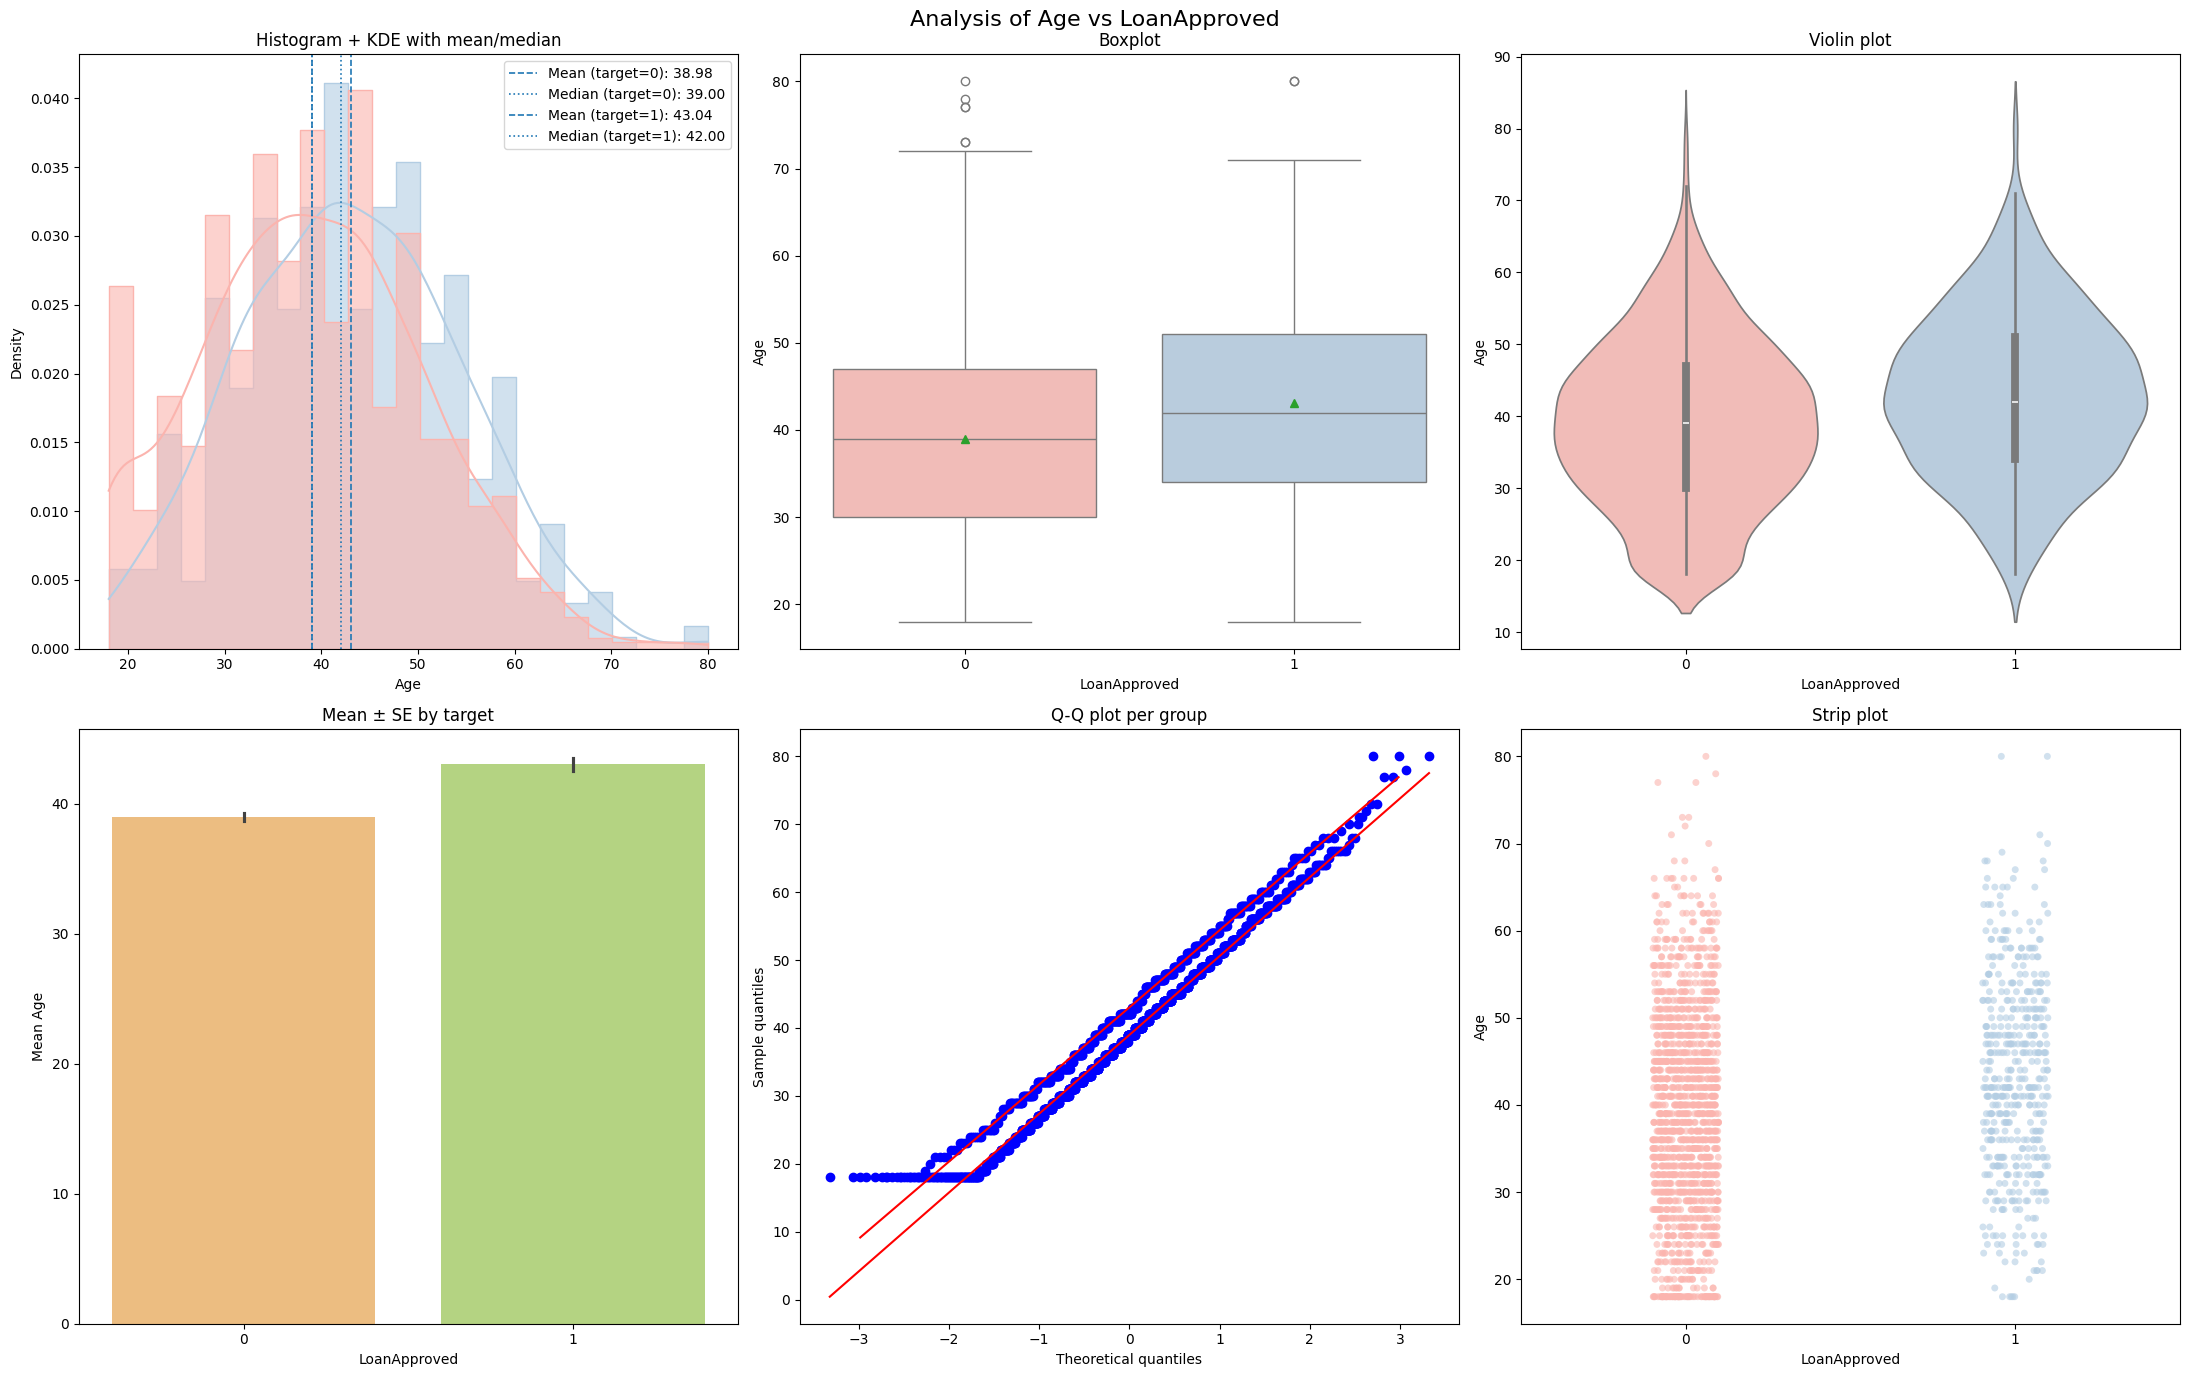

In [86]:
plot_numerical_vs_target(bank_data, 'Age', 'LoanApproved')

/tmp/ipython-input-3032345582.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

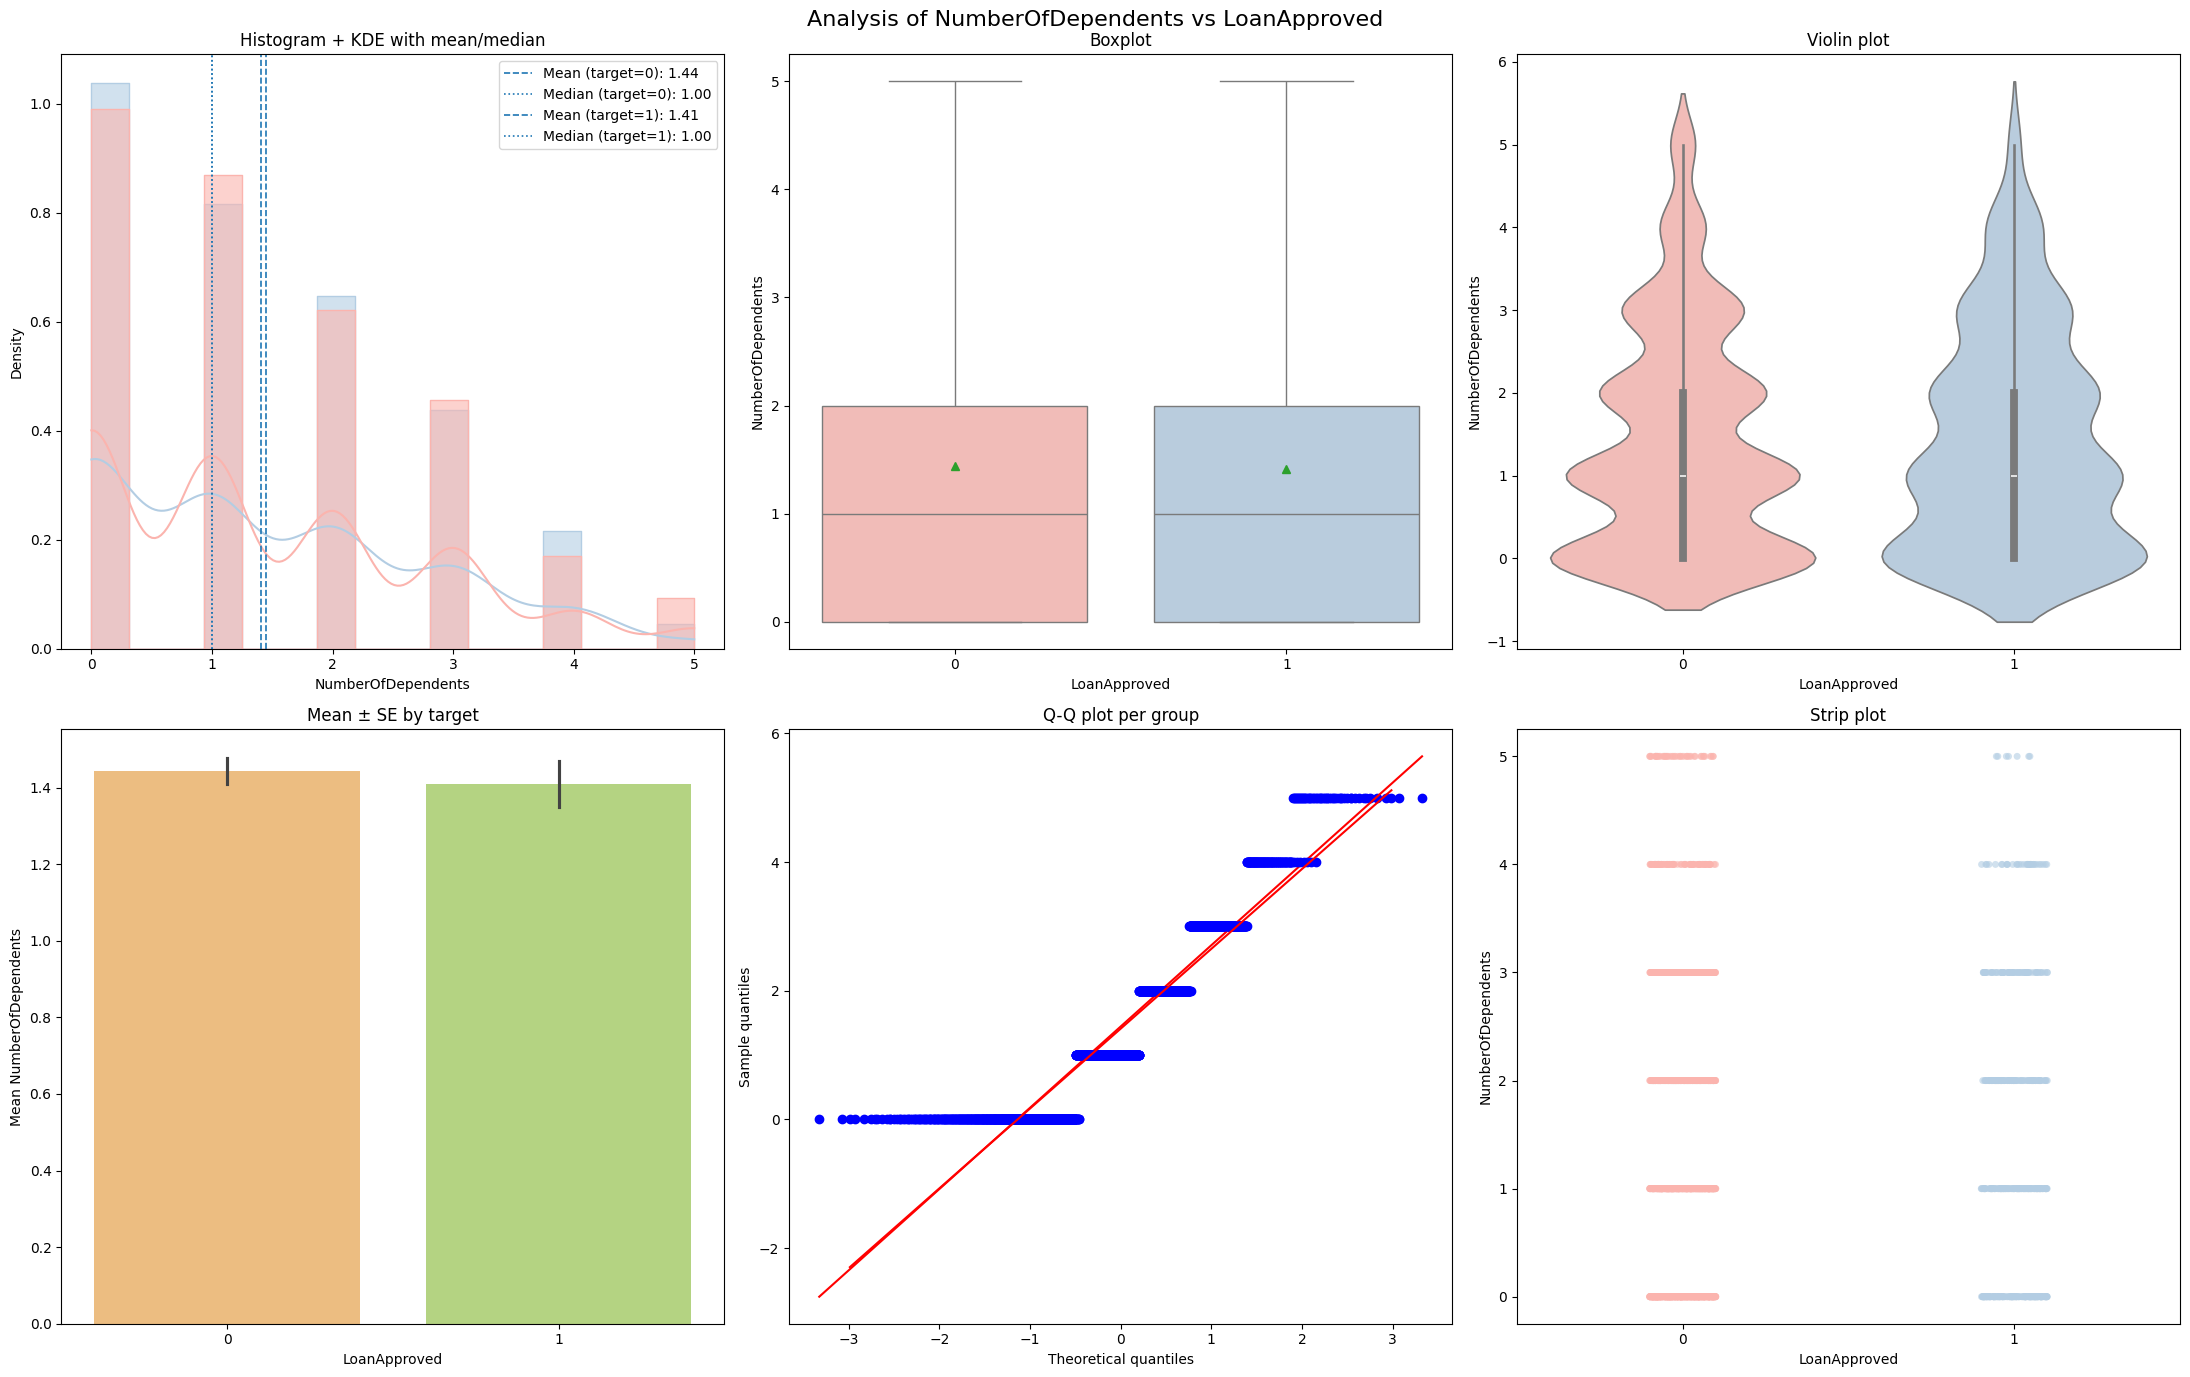

In [87]:
plot_numerical_vs_target(bank_data, 'NumberOfDependents', 'LoanApproved')

/tmp/ipython-input-3032345582.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

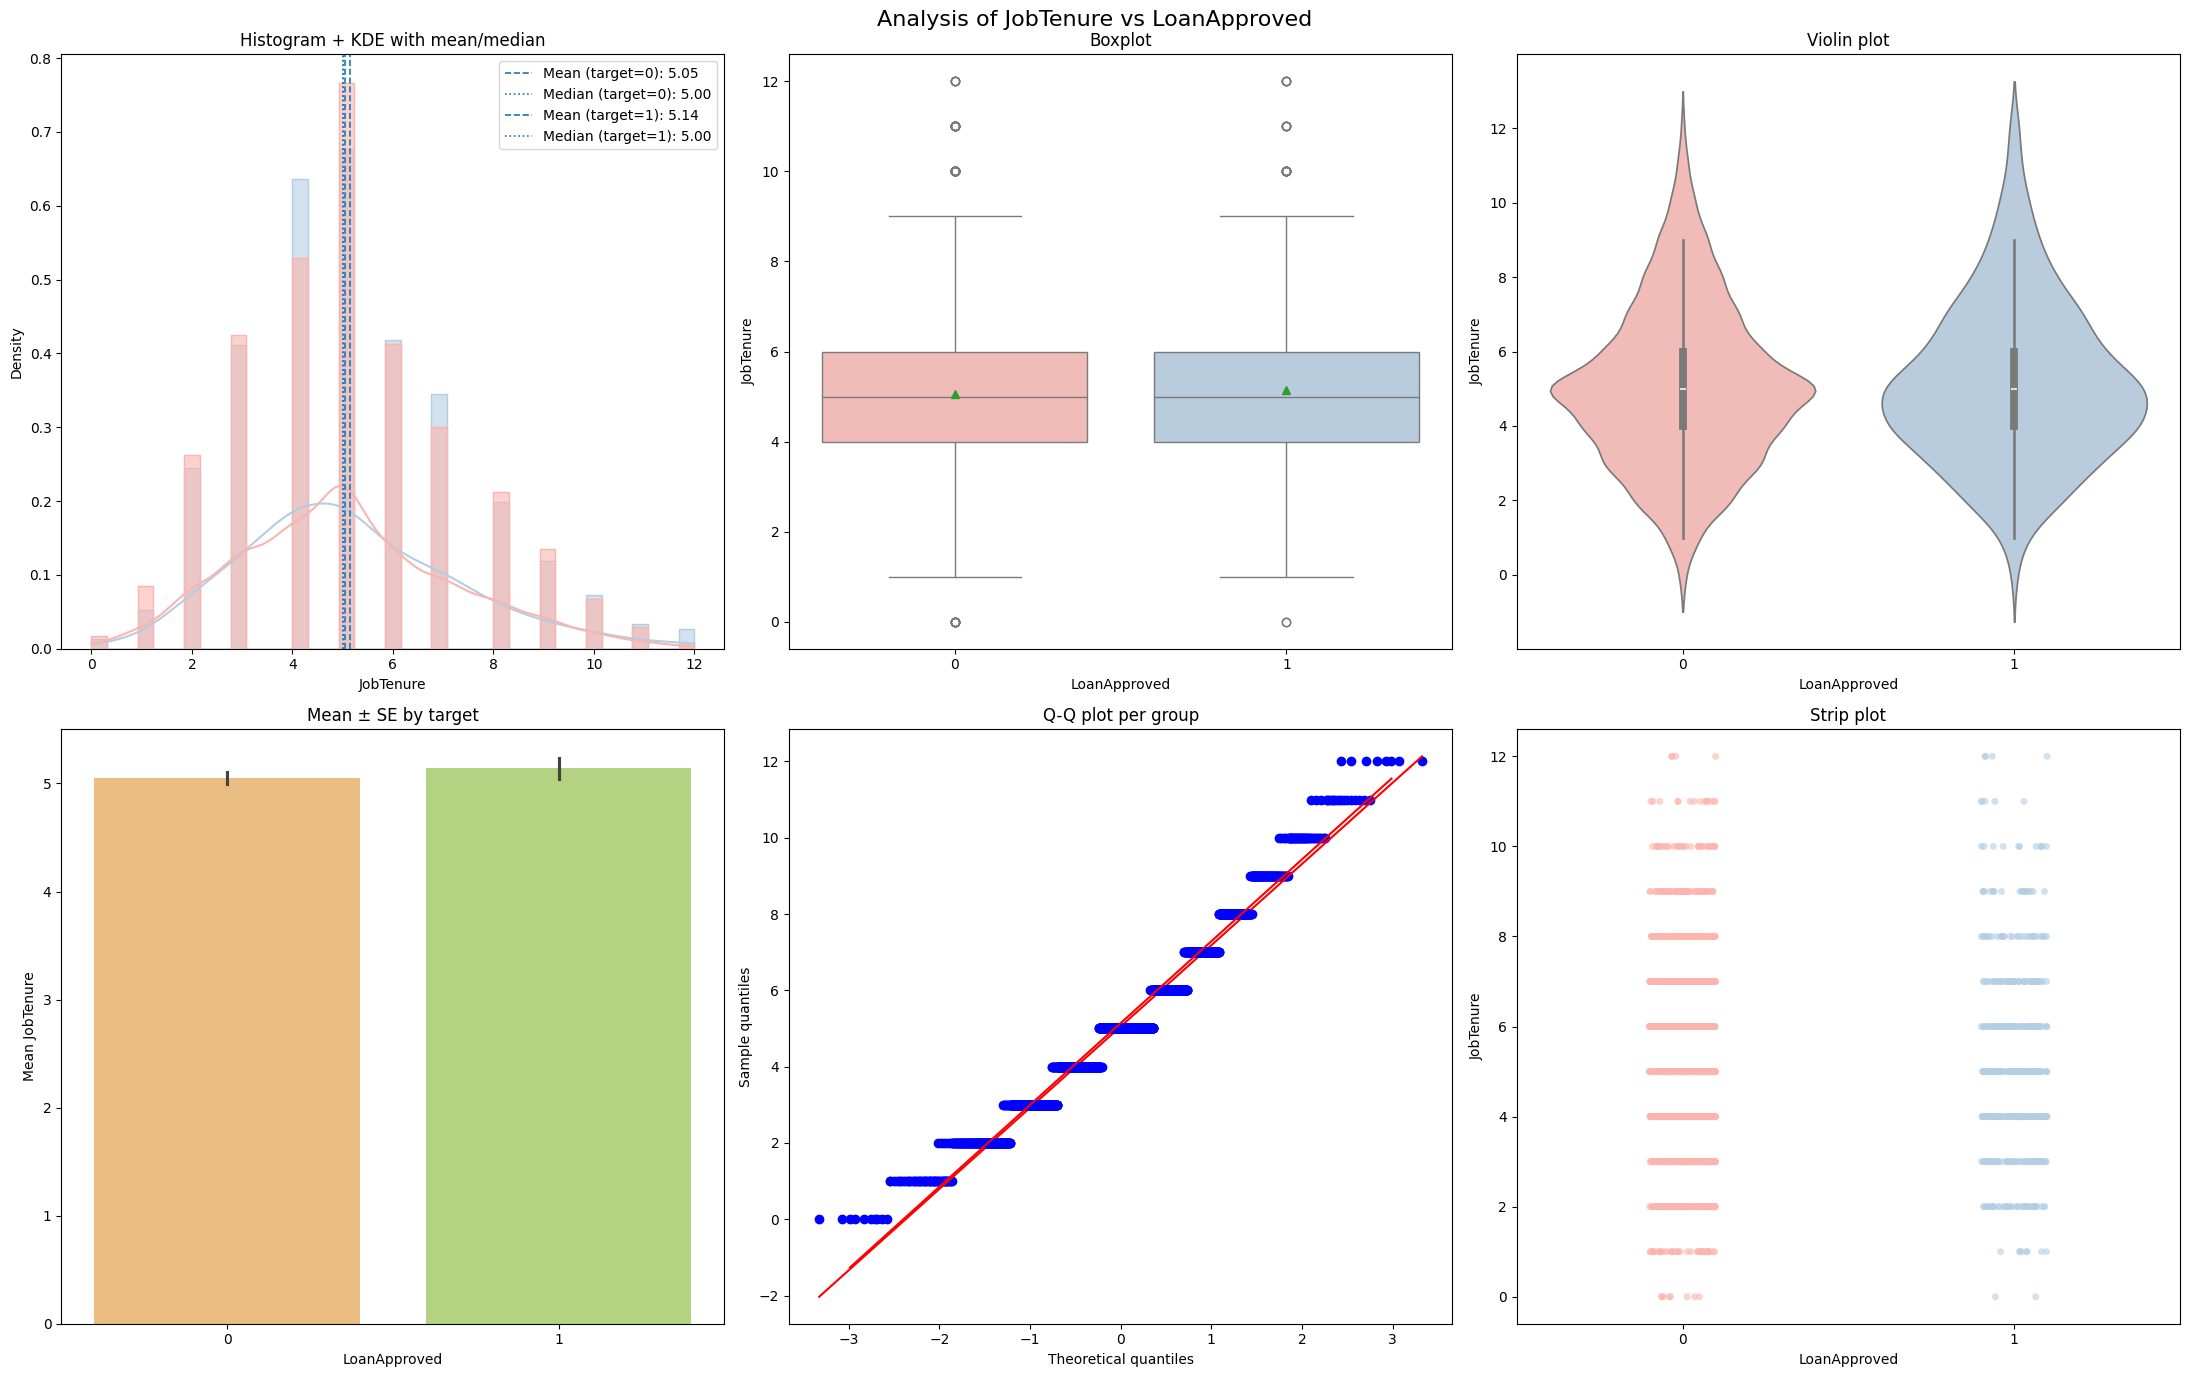

In [97]:
plot_numerical_vs_target(bank_data, 'JobTenure', 'LoanApproved')

/tmp/ipython-input-3032345582.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=target_col, y=feature_col,
/tmp/ipython-input-3032345582.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

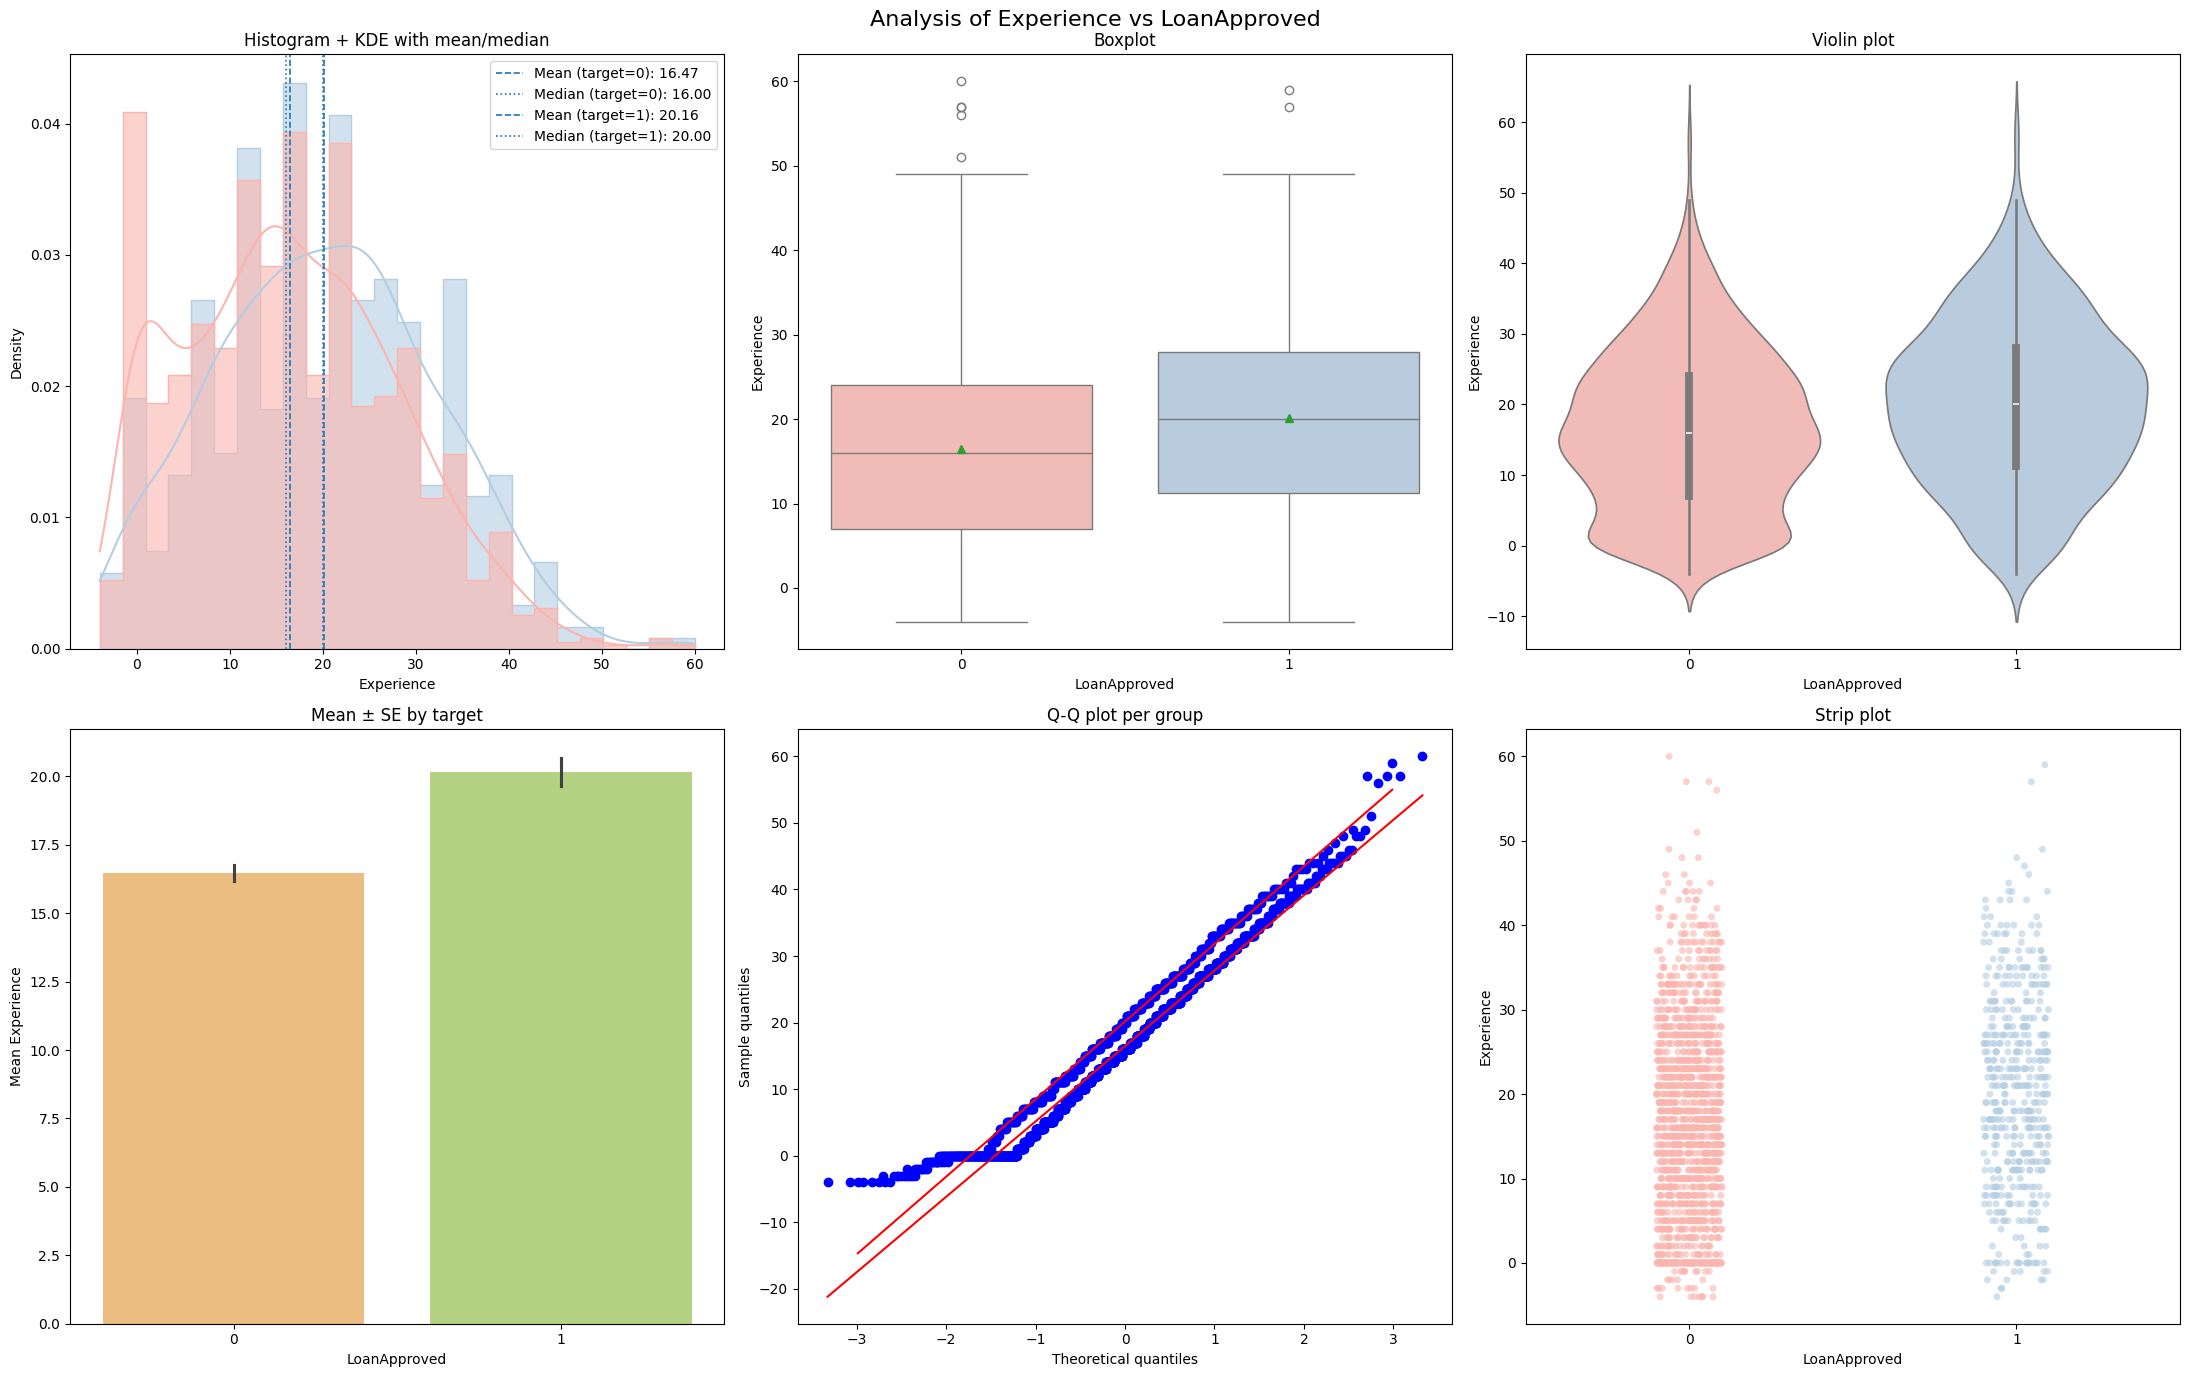

In [98]:
plot_numerical_vs_target(bank_data, 'Experience', 'LoanApproved')

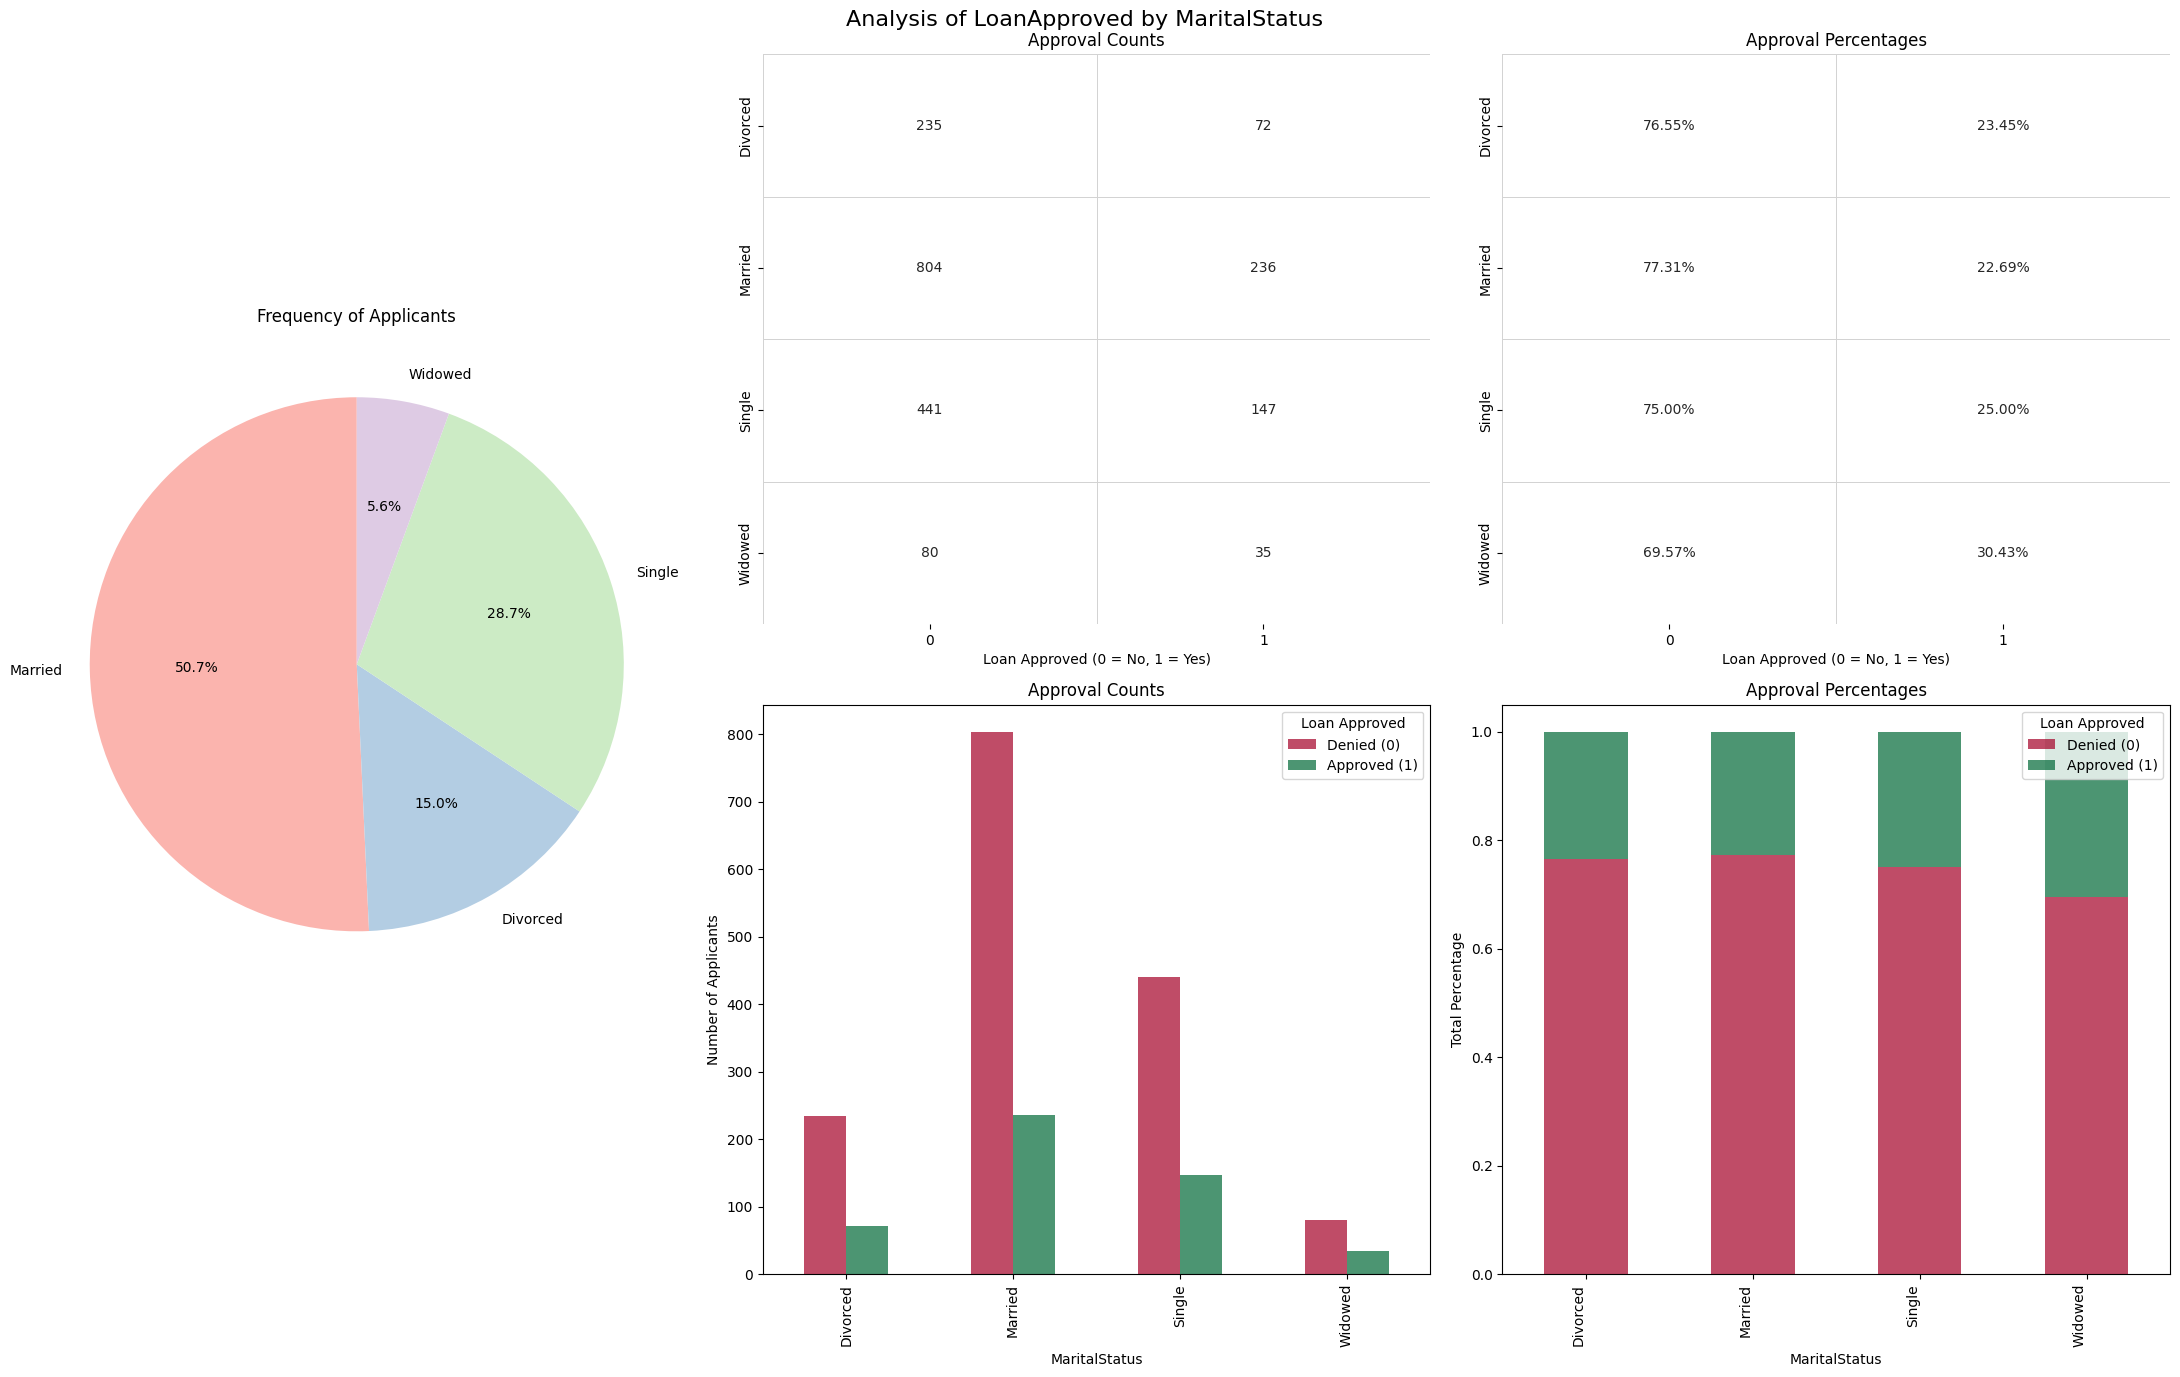

In [100]:
plot_categorical_vs_target(bank_data, 'MaritalStatus', 'LoanApproved')

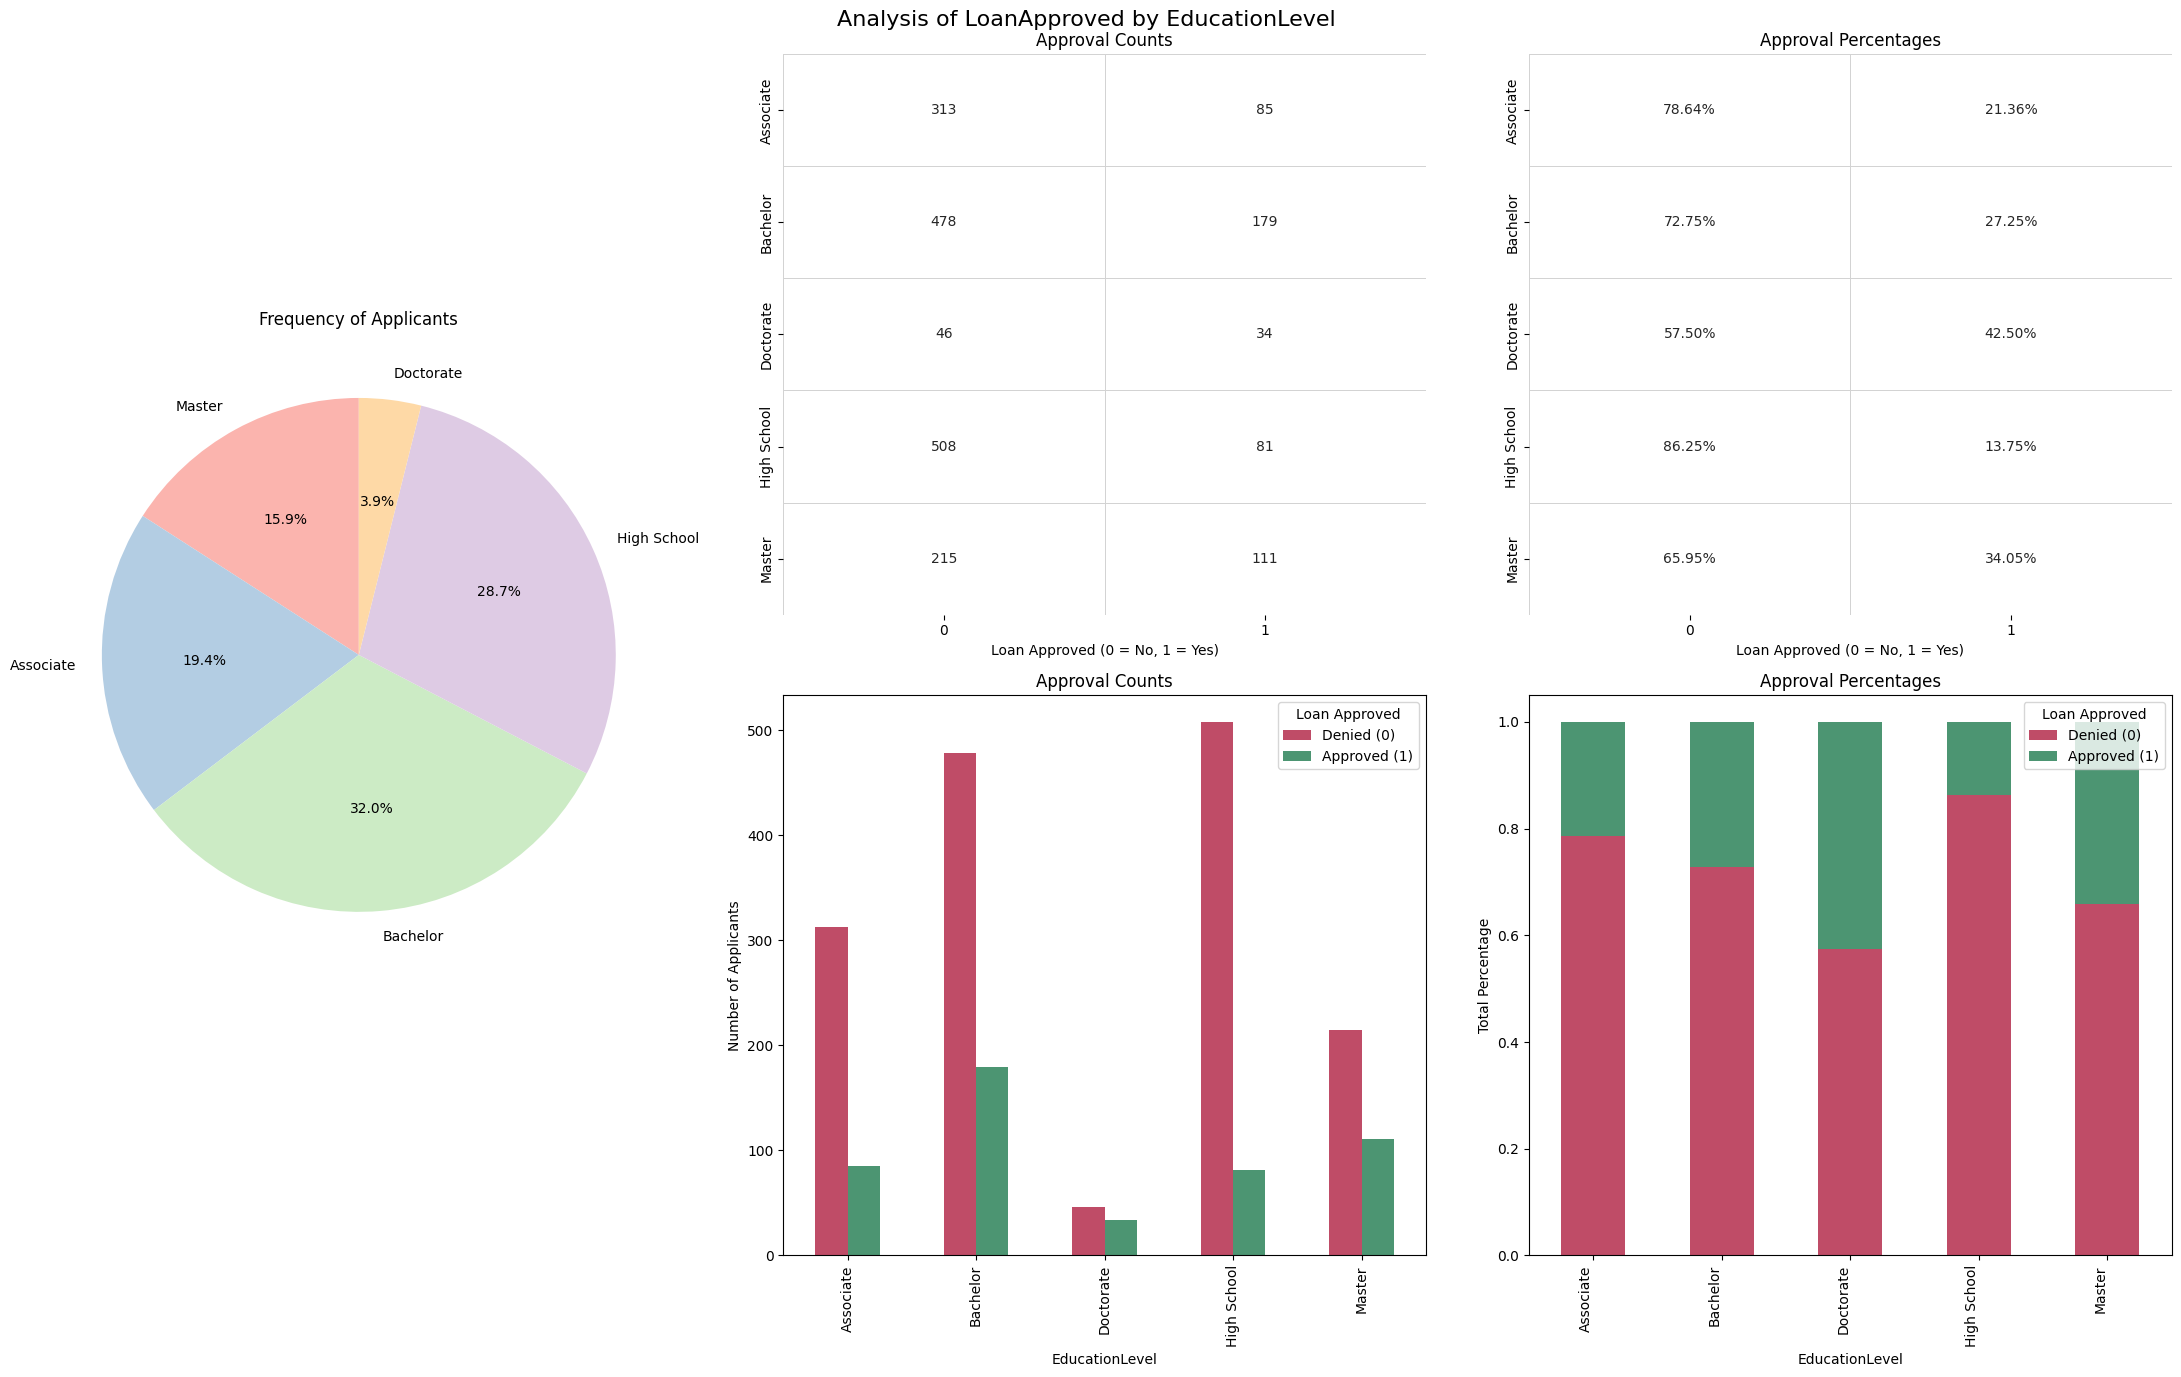

In [101]:
plot_categorical_vs_target(bank_data, 'EducationLevel', 'LoanApproved')

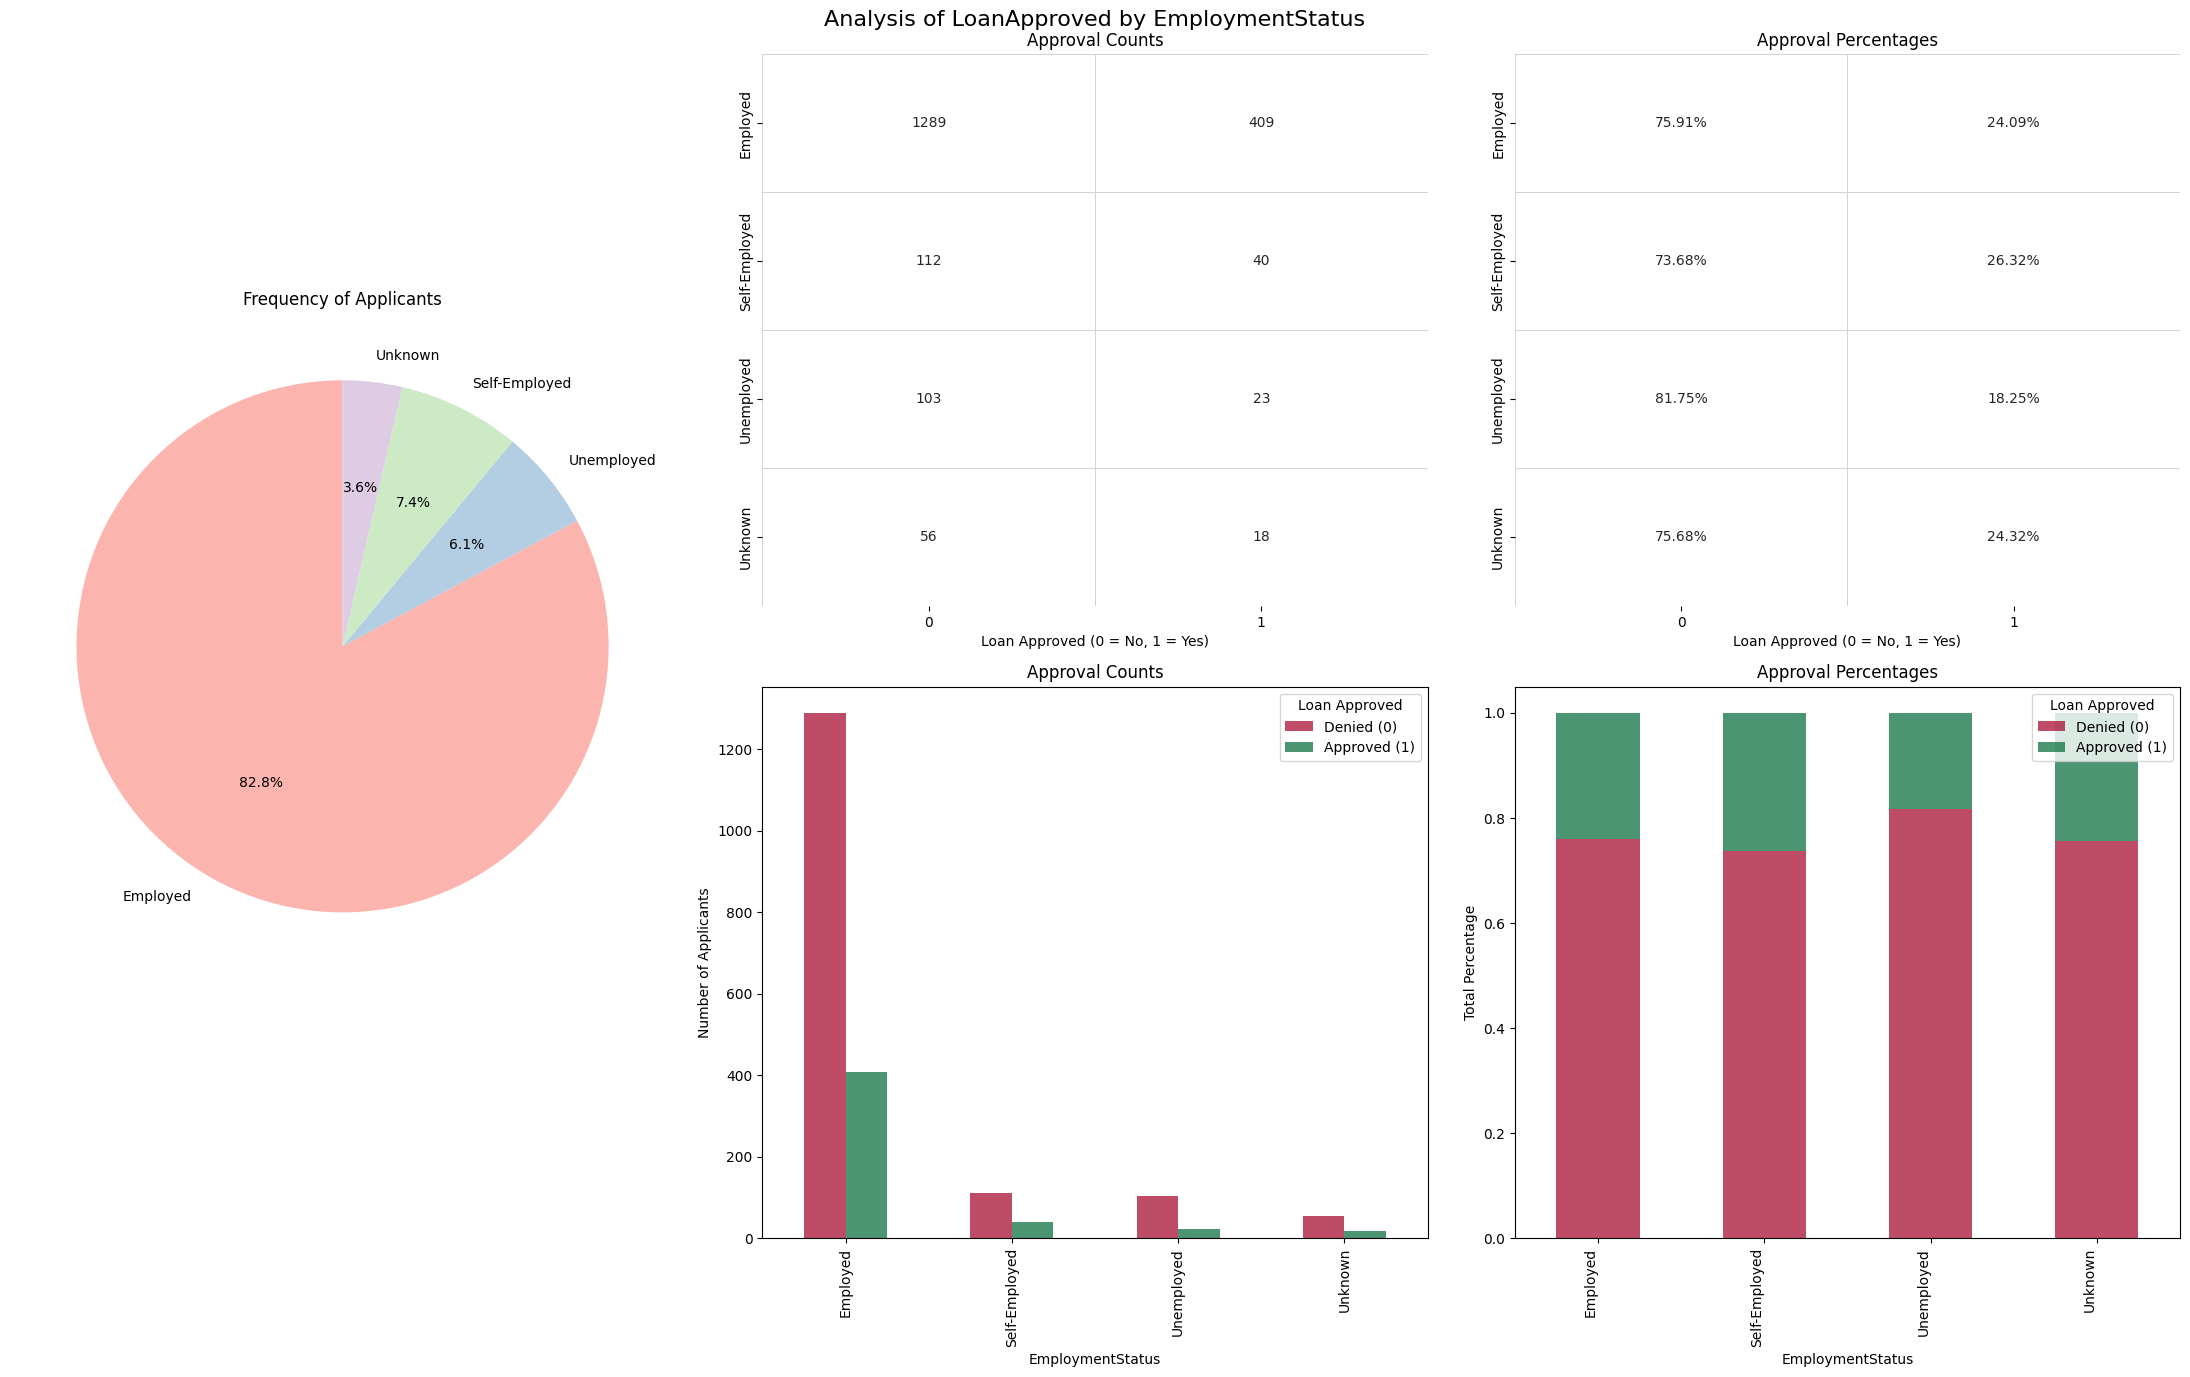

In [102]:
plot_categorical_vs_target(bank_data, 'EmploymentStatus', 'LoanApproved')

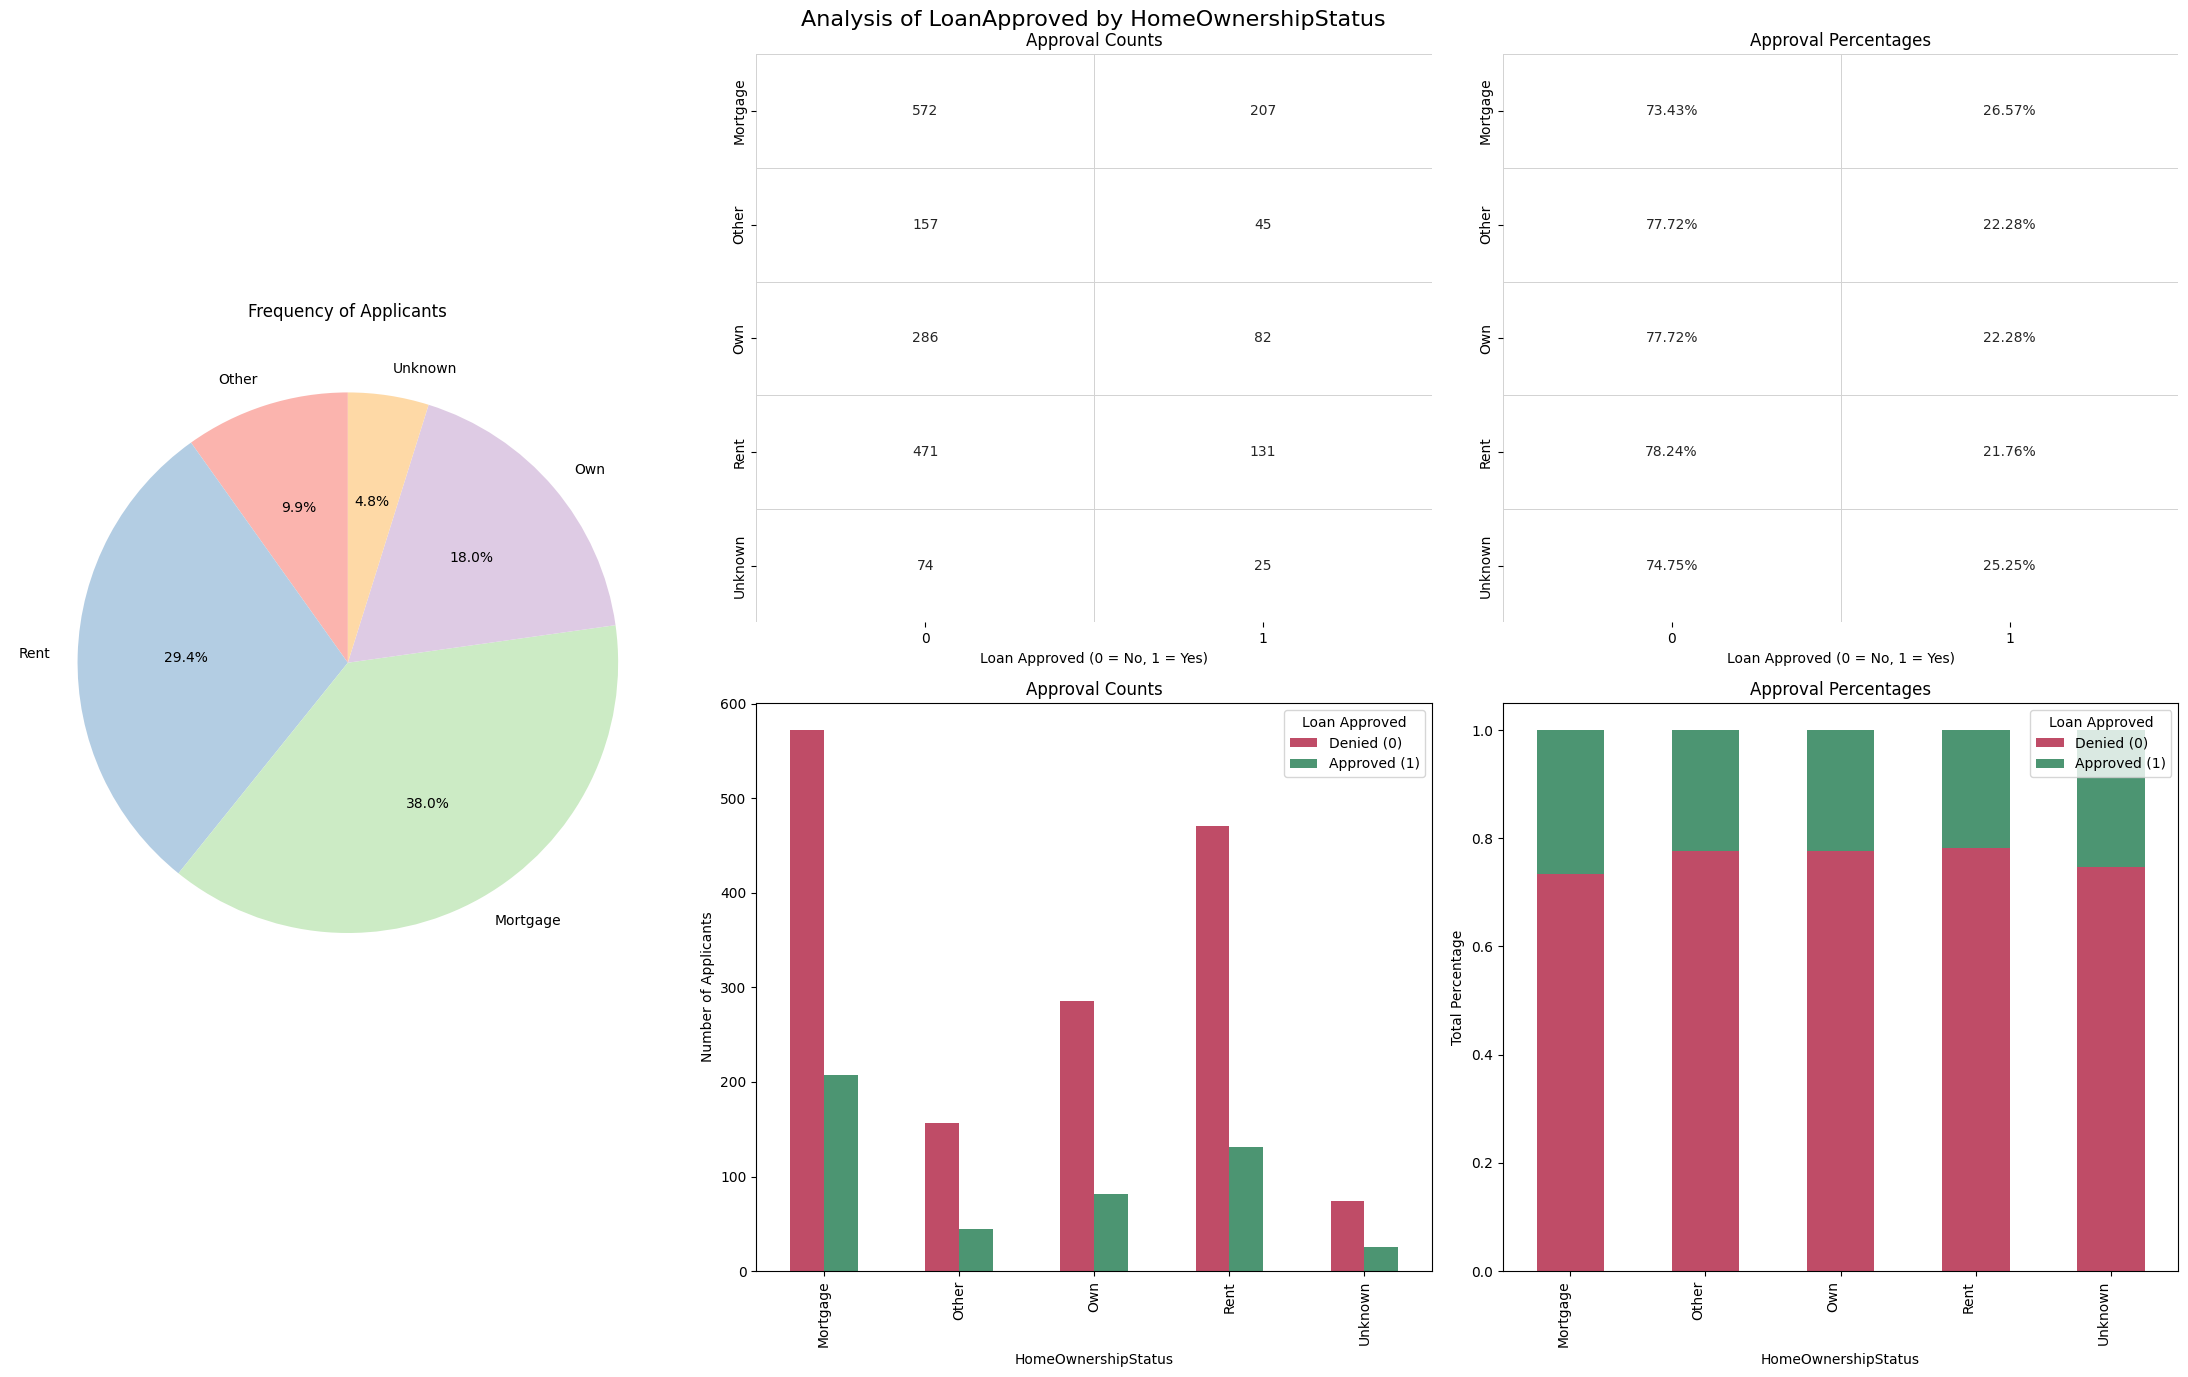

In [103]:
plot_categorical_vs_target(bank_data, 'HomeOwnershipStatus', 'LoanApproved')

From the Visuals Age and Exprience could be related


In [105]:
mann_whitney_u_test(bank_data, target_col="LoanApproved", col="Age")

Initiating Mann-Whitney U Test for Age vs LoanApproved, H0: No Effect, H1: Has Effect
U-Statistic: 456923.5000
P-Value: 0.0000
Conclusion: Reject H0.
There's statistically significant evidence that Age has an effect on LoanApproved.


In [106]:
mann_whitney_u_test(bank_data, target_col="LoanApproved", col="Experience")

Initiating Mann-Whitney U Test for Experience vs LoanApproved, H0: No Effect, H1: Has Effect
U-Statistic: 451126.5000
P-Value: 0.0000
Conclusion: Reject H0.
There's statistically significant evidence that Experience has an effect on LoanApproved.


Yeey!!

In [107]:
mann_whitney_u_test(bank_data, target_col="LoanApproved", col="NumberOfDependents")

Initiating Mann-Whitney U Test for NumberOfDependents vs LoanApproved, H0: No Effect, H1: Has Effect
U-Statistic: 377960.0000
P-Value: 0.7020
Conclusion: Fail to reject H0.
There's no statistically significant evidence that NumberOfDependents has an effect on LoanApproved.


In [108]:
mann_whitney_u_test(bank_data, target_col="LoanApproved", col="JobTenure")

Initiating Mann-Whitney U Test for JobTenure vs LoanApproved, H0: No Effect, H1: Has Effect
U-Statistic: 388034.0000
P-Value: 0.6056
Conclusion: Fail to reject H0.
There's no statistically significant evidence that JobTenure has an effect on LoanApproved.


In [110]:
compare_group_chi2(bank_data, group_col='MaritalStatus', target_col='LoanApproved')

Initiating CHI-square test:
Categories to compare: ['Married' 'Divorced' 'Single' 'Widowed']
No significant difference between 'Married' and 'Divorced': 
Chi2=0.0406, p-value=0.8403
No significant difference between 'Married' and 'Single': 
Chi2=0.9873, p-value=0.3204
No significant difference between 'Married' and 'Widowed': 
Chi2=3.0389, p-value=0.0813
No significant difference between 'Divorced' and 'Single': 
Chi2=0.1842, p-value=0.6678
No significant difference between 'Divorced' and 'Widowed': 
Chi2=1.8017, p-value=0.1795
No significant difference between 'Single' and 'Widowed': 
Chi2=1.2111, p-value=0.2711


In [111]:
compare_group_chi2(bank_data, group_col='EducationLevel', target_col='LoanApproved')

Initiating CHI-square test:
Categories to compare: ['Master' 'Associate' 'Bachelor' 'High School' 'Doctorate']
Significant difference between 'Master' and 'Associate': 
Chi2=13.9870, p-value=0.0002
Significant difference between 'Master' and 'Bachelor': 
Chi2=4.5283, p-value=0.0333
Significant difference between 'Master' and 'High School': 
Chi2=50.9237, p-value=0.0000
No significant difference between 'Master' and 'Doctorate': 
Chi2=1.6470, p-value=0.1994
Significant difference between 'Associate' and 'Bachelor': 
Chi2=4.2719, p-value=0.0387
Significant difference between 'Associate' and 'High School': 
Chi2=9.2820, p-value=0.0023
Significant difference between 'Associate' and 'Doctorate': 
Chi2=14.8151, p-value=0.0001
Significant difference between 'Bachelor' and 'High School': 
Chi2=33.4299, p-value=0.0000
Significant difference between 'Bachelor' and 'Doctorate': 
Chi2=7.3514, p-value=0.0067
Significant difference between 'High School' and 'Doctorate': 
Chi2=38.8971, p-value=0.0000

In [112]:
compare_group_chi2(bank_data, group_col='EmploymentStatus', target_col='LoanApproved')

Initiating CHI-square test:
Categories to compare: ['Employed' 'Unemployed' 'Self-Employed' 'Unknown']
No significant difference between 'Employed' and 'Unemployed': 
Chi2=1.8972, p-value=0.1684
No significant difference between 'Employed' and 'Self-Employed': 
Chi2=0.2655, p-value=0.6064
No significant difference between 'Employed' and 'Unknown': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Unemployed' and 'Self-Employed': 
Chi2=2.1155, p-value=0.1458
No significant difference between 'Unemployed' and 'Unknown': 
Chi2=0.7145, p-value=0.3979
No significant difference between 'Self-Employed' and 'Unknown': 
Chi2=0.0254, p-value=0.8734


This was suprising for me tho!

In [113]:
compare_group_chi2(bank_data, group_col='HomeOwnershipStatus', target_col='LoanApproved')

Initiating CHI-square test:
Categories to compare: ['Other' 'Rent' 'Mortgage' 'Own' 'Unknown']
No significant difference between 'Other' and 'Rent': 
Chi2=0.0031, p-value=0.9559
No significant difference between 'Other' and 'Mortgage': 
Chi2=1.3335, p-value=0.2482
No significant difference between 'Other' and 'Own': 
Chi2=0.0000, p-value=1.0000
No significant difference between 'Other' and 'Unknown': 
Chi2=0.1839, p-value=0.6680
Significant difference between 'Rent' and 'Mortgage': 
Chi2=3.9970, p-value=0.0456
No significant difference between 'Rent' and 'Own': 
Chi2=0.0122, p-value=0.9120
No significant difference between 'Rent' and 'Unknown': 
Chi2=0.4143, p-value=0.5198
No significant difference between 'Mortgage' and 'Own': 
Chi2=2.2181, p-value=0.1364
No significant difference between 'Mortgage' and 'Unknown': 
Chi2=0.0255, p-value=0.8732
No significant difference between 'Own' and 'Unknown': 
Chi2=0.2396, p-value=0.6245


There was a Diffrence between diferent Educational Levels as well (Make sence)

In [ ]:
compare_group_chi2(bank_data, group_col='EducationLevel', target_col='LoanApproved')

### Static Tests

In [ ]:
results_df = correlation_with_target(bank_data, "LoanApproved", alpha=0.05)
results_df

,Feature,Test Used,Statistic,P-value,Result,Normality Tests,Variance Assumption
0,Age,Mann–Whitney U,307476.5,6.165603e-11,Significant,KS/KS,Equal var
1,AnnualIncome,Mann–Whitney U,97383.0,4.733222e-137,Significant,KS/KS,Equal var
2,CreditScore,Mann–Whitney U,310618.5,3.786096e-10,Significant,KS/KS,Equal var
3,Experience,Mann–Whitney U,313273.5,1.603398e-09,Significant,KS/KS,Equal var
4,LoanDuration,Mann–Whitney U,428615.5,3.859581e-05,Significant,KS/KS,Unequal var
5,NumberOfDependents,Mann–Whitney U,386440.0,7.019773e-01,Not significant,KS/KS,Equal var
6,MonthlyDebtPayments,Mann–Whitney U,424194.5,2.387878e-04,Significant,KS/KS,Equal var
7,CreditCardUtilizationRate,Mann–Whitney U,389838.0,5.040136e-01,Not significant,KS/KS,Equal var
8,NumberOfOpenCreditLines,Mann–Whitney U,381436.0,9.459093e-01,Not significant,KS/KS,Equal var
9,NumberOfCreditInquiries,Mann–Whitney U,358672.5,2.919874e-02,Significant,KS/KS,Equal var
